# Numerov-based POD+Greedy Emulator for two-body scattering

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")

import numpy as np
import matplotlib.pyplot as plt

from Potential import Potential
from Channel import Channel
from ScatteringExp import ScatteringExp
from Grid import Grid
from RseSolver import RseSolver
from scipy.special import factorial2, spherical_jn
from plots.rc_params import *

## Warm up: solve Schrödinger equation using Runge Kutta

In [2]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
# lvalues = [0]
# channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 

l = 2
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

# generate training data
rmatch = 12
# rmin = np.min((0.1, (factorial2(2*l+1) * 1e-4)**(1/(l+1)) / scattExp.p))
rmin = 1e-12 
assert rmin < 1, "rmin > 1"
# print(f"rmin: {rmin}")
grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
            type="linear", test=False) 

In [10]:
inhomogeneous=False
scattSols_numerov = RseSolver.solve(scattExp, grid, testingLecList, 
                            method="Numerov", inhomogeneous=inhomogeneous,
                            asympParam="K", matching=True)
scattSols_rk45 = RseSolver.solve(scattExp, grid, testingLecList, 
                            method="RK45", inhomogeneous=inhomogeneous,
                            asympParam="K", matching=True)

# plt.plot(grid.points, np.real(scattSols_rk45[0].u), label="RK45")
# plt.plot(grid.points, np.real(scattSols_numerov[0].u), label="Numerov")
pr = grid.points * scattExp.p
plt.figure(figsize=(4,3))
# plt.plot(grid.points, spherical_jn(l, pr) * pr, ls=":", label="exact")
plt.plot(grid.points, np.real(scattSols_numerov[0].u-scattSols_rk45[0].u), label="diff")
# plt.plot(grid.points, 
#          np.real(scattSols_numerov[0].u-0*spherical_jn(l, pr) * pr),  
#          label="diff exact Numerov")
# plt.plot(grid.points, 
#          np.real(scattSols_rk45[0].u-0*spherical_jn(l, pr) * pr),  
#          label="diff exact RK")
plt.xlabel("$r$")
plt.ylabel("$y(r)$")
# plt.xlim(-0.1,0.1)
plt.title(f"$\ell = {l}$")
plt.legend()

a = scattSols_numerov[0].Lmatrix.phaseShift
b = scattSols_rk45[0].Lmatrix.phaseShift
print("phaseshifts", a,b, np.abs(a-b))

TypeError: RseSolver.solve() got an unexpected keyword argument 'inhomogeneous'

In [ ]:
inhomogeneous=True
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList_=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList_dict=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList_dict=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))

testing


TypeError: RseSolver.solve() got an unexpected keyword argument 'lecList_dict'

In [68]:
solver.solve(lecList_dict=testingLecList, method="Numerov_affine", reduced_output=True, **args)[1]

array([0.12807611])

In [77]:
inhomogeneous=False
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList_dict=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList_dict=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList_dict=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))
np.max(np.abs(num1[0].uprime - (num1[0].chiprime + num1[0].free_solutions_F_G(derivative=True)[:,0]) / scattExp.p))

testing
diff 4.166389455662056e-13
diff 4.797976183024133e-10


1.1102230246251565e-16

In [13]:
inhomogeneous=True
args = dict(lecList=testingLecList, asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(method="Numerov_affine", **args)
num2  = solver.solve(method="Numerov", **args)
numk  = solver.solve(method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))
np.max(np.abs(num1[0].uprime - (num1[0].chiprime + num1[0].free_solutions_F_G(derivative=True)[:,0]) / scattExp.p))

testing
diff 1.202926647181357e-13
diff 1.4836676331952958e-10


1.1102230246251565e-16

testing


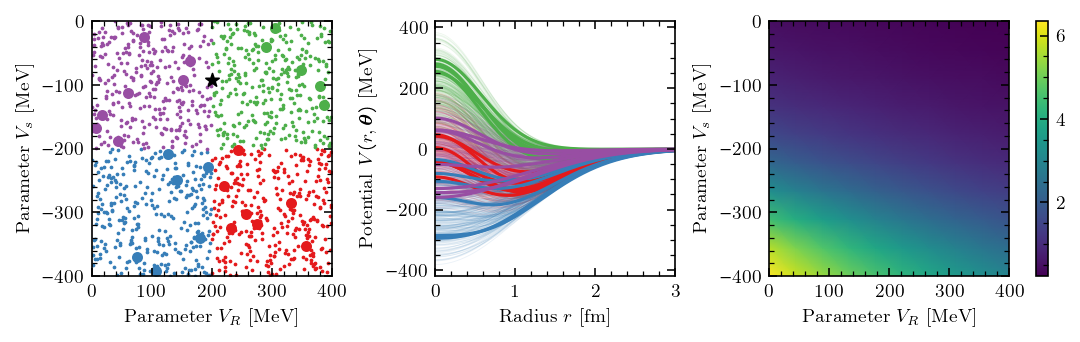

In [10]:
cm = 1./2.54
from constants import hbarc
fig, axs = plt.subplots(1,3, figsize=(18*cm,5.5*cm), constrained_layout=True)

for index, n in enumerate((1250, 25)):
    param_samples_all = potential.getLecsSample({"V0": (0, 400), "V1": (-400, 0)}, n=n)
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    size_marker = [1, 20][index]
    size_line = [0.4, 1.5][index]
    alpha_lines = (0.1, 1.)[index]
        
    grid_plot = np.linspace(0, 4, 200)

    color = colors[0]
    mask = np.logical_and(param_samples_plot[:, 0] > 200, param_samples_plot[:, 1] < -200)
    axs[0].scatter(param_samples_plot[mask,0], param_samples_plot[mask,1], color=color, s=size_marker)

    for ilec, lec_sample in enumerate(param_samples_all):
        if not mask[ilec]: 
            continue 
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines)

    color = colors[1]
    mask = np.logical_and(param_samples_plot[:, 0] < 200, param_samples_plot[:, 1] < -200)
    axs[0].scatter(param_samples_plot[mask,0], param_samples_plot[mask,1], color=color, s=size_marker)

    for ilec, lec_sample in enumerate(param_samples_all):
        if not mask[ilec]: 
            continue 
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines)

    color = colors[2]
    mask = np.logical_and(param_samples_plot[:, 0] > 200, param_samples_plot[:, 1] > -200)
    axs[0].scatter(param_samples_plot[mask,0], param_samples_plot[mask,1], color=color, s=size_marker)

    for ilec, lec_sample in enumerate(param_samples_all):
        if not mask[ilec]: 
            continue 
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines)

    color = colors[3]
    mask = np.logical_and(param_samples_plot[:, 0] < 200, param_samples_plot[:, 1] > -200)
    axs[0].scatter(param_samples_plot[mask,0], param_samples_plot[mask,1], color=color, s=size_marker)
    
    for ilec, lec_sample in enumerate(param_samples_all):
        if not mask[ilec]: 
            continue 
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines)
        
axs[0].scatter(potential.lecBaseValues["V0"], 
               potential.lecBaseValues["V1"], color="k", s=45, marker="*")
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(0,400)
axs[0].set_ylim(-400,0)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")

solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=True)
# num1  = solver.solve(lecList_=testingLecList, method="Numerov_affine", **args)

num_theta1 = 10
num_theta2 = 10
theta1 = np.linspace(0, 400, num_theta1)
theta2 = np.linspace(-400, 0, num_theta2)
min_sv = np.zeros((num_theta2, num_theta1))
# cond = np.zeros((num_theta2, num_theta1))
import scipy.linalg as spla
for j, t1 in enumerate(theta1):
    for i, t2 in enumerate(theta2):
        theta_vec = np.array([1, t1, t2])
        A_theta_vec, _ = solver.numerov_solver.get_linear_system(theta_vec, ret_diag_form=False, file_dump=False)
        s_theta_vec = spla.svdvals(A_theta_vec)
        min_sv[i, j] = s_theta_vec[-1] * 1e7
        # cond[i, j] = s_theta_vec[0] / s_theta_vec[-1]

out = axs[2].pcolormesh(theta1, theta2, min_sv, shading='gouraud')
axs[2].set_xlabel("Parameter $V_R$ [MeV]")
axs[2].set_ylabel("Parameter $V_s$ [MeV]")
axs[2].set_xlim(0,400)
axs[2].set_ylim(-400,0)
_ = fig.colorbar(out)
fig.savefig("minnesota_parameter_space_partition_sval.png", dpi=200)

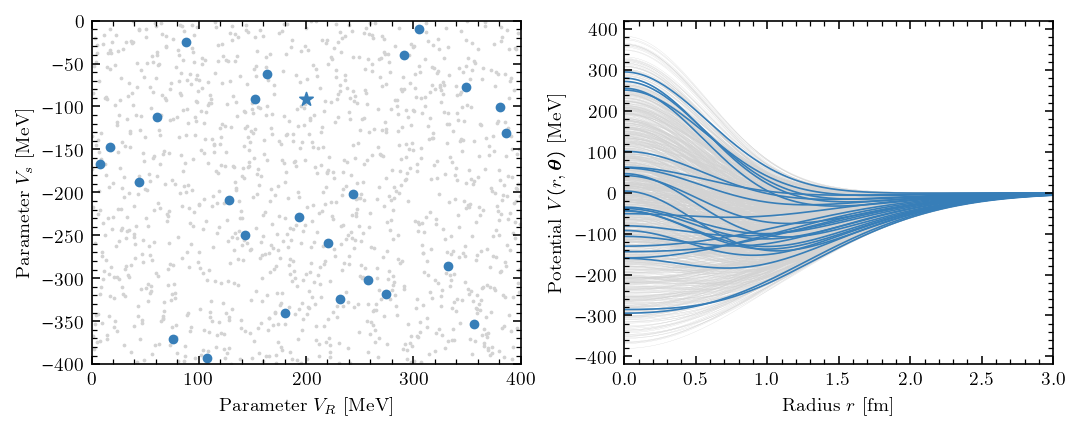

In [127]:
cm = 1./2.54
from constants import hbarc
fig, axs = plt.subplots(1,2, figsize=(18*cm,7*cm), constrained_layout=True)

for index, n in enumerate((1250, 25)):
    param_samples_all = potential.getLecsSample({"V0": (0, 400), "V1": (-400, 0)}, n=n)
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    color = ("lightgray", colors[1])[index]
    size = [1, 15][index]
    axs[0].scatter(param_samples_plot[:,0], param_samples_plot[:,1], color=color, s=size)
    
    grid_plot = np.linspace(0, 4, 200)
    size = [1.2, 8][index]
    for lec_sample in param_samples_all:
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size/10)

axs[0].scatter(potential.lecBaseValues["V0"], 
               potential.lecBaseValues["V1"], color=color, s=45, marker="*")
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(0,400)
axs[0].set_ylim(-400,0)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
fig.savefig("minnesota_parameter_space.png", dpi=200)

[{'V0': 369.2705925470074, 'V1': -244.2152840752089, 'K0': 1.487, 'K1': 0.465},
 {'V0': 347.1185605089096, 'V1': -76.73748724279466, 'K0': 1.487, 'K1': 0.465},
 {'V0': 199.29637639565988,
  'V1': -31.248378026623072,
  'K0': 1.487,
  'K1': 0.465},
 {'V0': 324.30662000789175,
  'V1': -173.10629759118842,
  'K0': 1.487,
  'K1': 0.465},
 {'V0': 168.720981753628, 'V1': -35.55957077244477, 'K0': 1.487, 'K1': 0.465},
 {'V0': 65.94811817908187, 'V1': -300.9798584042752, 'K0': 1.487, 'K1': 0.465},
 {'V0': 4.703033615610355,
  'V1': -396.85505185350036,
  'K0': 1.487,
  'K1': 0.465},
 {'V0': 313.03413179106116,
  'V1': -290.51976081835875,
  'K0': 1.487,
  'K1': 0.465},
 {'V0': 0.29037096589933187,
  'V1': -64.9276327544257,
  'K0': 1.487,
  'K1': 0.465},
 {'V0': 128.80349948551967,
  'V1': -166.07266014741086,
  'K0': 1.487,
  'K1': 0.465},
 {'V0': 263.07377750073175, 'V1': -224.663615972963, 'K0': 1.487, 'K1': 0.465},
 {'V0': 210.00884412600885,
  'V1': -238.33089856246127,
  'K0': 1.487,
  '

In [33]:
inhomogeneous=False
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList_dict=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList_dict=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList_dict=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))

testing
diff 4.166389455662056e-13
diff 4.797976183024133e-10


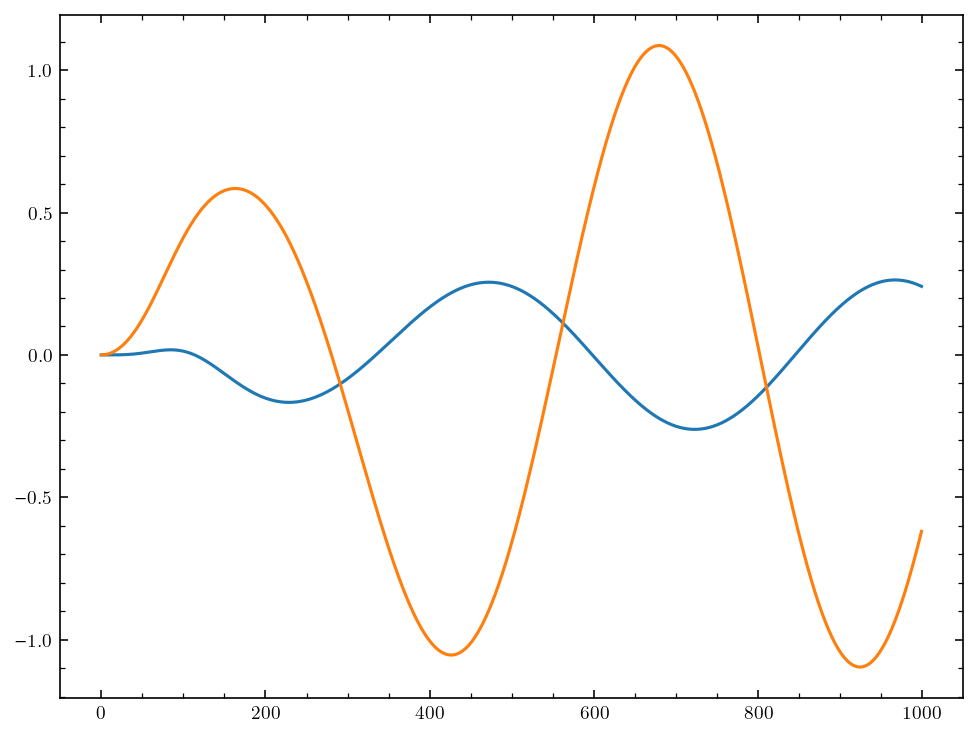

In [ ]:
plt.plot(num1[0].chiprime)
plt.plot(num1[0].uprime)

In [ ]:
ab = np.loadtxt("orig_ab.csv")
rhs = np.loadtxt("orig_s.csv")
A = np.loadtxt("class_A.csv")
s = np.loadtxt("class_s.csv")
print(np.max(np.abs(A-ab)))
print(np.max(np.abs(s-rhs)))

4.440892098500626e-16
5.551115123125783e-17


In [ ]:
from Numerov import diag_ord_form_to_mat
np.linalg.cond(diag_ord_form_to_mat(A, (2,0), toarray=True)[1:,1:])

367172.8170310892

In [ ]:
# np.abs(num[0].u-num2[0].u)#

In [ ]:
nb = 5
ntheta = 10
ngrid = 1000

X = np.ones((ngrid, nb))
At = np.ones((ngrid, ngrid, ntheta))

print("Xshape", X.shape)
print("Atshape", At.shape)

%timeit np.tensordot(X.T, np.tensordot(At, X, axes=[1,0]), axes=[1,0]).shape

Xshape (1000, 5)
Atshape (1000, 1000, 10)
37.8 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
nb = 5
ntheta = 10
ngrid = 1000

X = np.ones((ngrid, nb))
At = np.ones((ntheta, ngrid, ngrid))
lec = np.ones(ntheta)

print("Xshape", X.shape)
print("Atshape", At.shape)

%timeit (X.T @ At @ X).shape
np.tensordot(lec, (X.T @ At @ X), axes=1).shape

Xshape (1000, 5)
Atshape (10, 1000, 1000)
4.8 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(5, 5)

## Benchmark Numerov

In [ ]:
def f(E_MeV, channel, inhomogeneous=True):
    potentialArgs = {"label": "chiral", "kwargs": {"potId": 213}}
    potential = Potential(channel, **potentialArgs)
    trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

    scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

    grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
                type="linear", test=False) 
    scattSols_numerov = RseSolver.solve(scattExp, grid, testingLecList, 
                                method="Numerov", inhomogeneous=inhomogeneous,
                                asympParam="K", matching=True)
    scattSols_rk45 = RseSolver.solve(scattExp, grid, testingLecList, 
                                method="RK45", inhomogeneous=inhomogeneous,
                                asympParam="K", matching=True)
    return [scattSols_numerov[0],
            scattSols_rk45[0]]  # Lmatrix.phaseShift

In [ ]:
lvalues = [0, 1, 2, 3, 4]
energies_MeV = [10.0,
20.0,
25.0,
50.0,
100.0]

for l in lvalues:
    channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
    for E_MeV in energies_MeV:
        res = f(E_MeV, channel, inhomogeneous=True)
        res = [res[0].Lmatrix.phaseShift, res[1].Lmatrix.phaseShift]
        # print(f"l = {l} | E = {E_MeV} | {np.real(res)[0]}") 
        # print(f"{np.real(res)[0]}") 
        print(f"{np.abs(res[0]-res[1])}") 
    print()


7.691034653589668e-08
6.721351297755973e-08
6.648935624298247e-08
8.224466441220102e-08
1.7840128840873604e-07

9.63403579135047e-10
3.902020040413845e-09
6.2748686247005026e-09
3.1421905077877454e-08
1.5629652949655792e-07

1.8845147664592332e-11
3.136362280997673e-10
5.669067437708009e-10
4.316599522269371e-09
2.523817954624974e-08

1.2856382625159313e-11
3.129586589878386e-10
9.600933381648247e-10
8.462230027816986e-09
5.70108906750022e-08

8.677291524206154e-11
2.787643726964717e-11
3.576594576060188e-11
1.1687456002995589e-09
1.2410865224410372e-08



working on 1S0
working on 1P1
working on 1D2
working on 1F3
working on 1G4


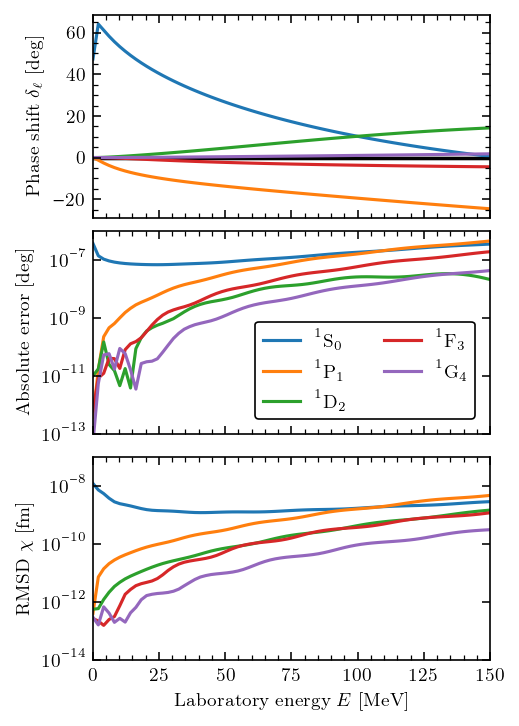

In [ ]:
# %pip install pandas
import pandas as pd
lvalues = [0, 1, 2, 3, 4] # , 8] # , 12]
channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 
cm = 1./2.54
energies_MeV = np.linspace(1e-1, 150, 75)
fig, axs = plt.subplots(3,1, sharex=True, figsize=(8.5*cm,12*cm), constrained_layout=True)

for channel in channels:
    print("working on", channel.spectNotation)
    ret_raw = []
    for E_MeV in energies_MeV:
        ret_raw.append(f(E_MeV=E_MeV, channel=channel))

    ret = np.array([[elem[0].Lmatrix.phaseShift, elem[1].Lmatrix.phaseShift] for elem in ret_raw])
    df = pd.DataFrame(data={"Energies": energies_MeV,
                            "Numerov": ret[:,0], 
                            "RK45": ret[:,1]})
    df.to_csv(f"phase_shifts_chiral_{channel.spectNotation}")

    axs[0].plot(energies_MeV, np.real(ret[:,0]))
    axs[0].set_ylabel("Phase shift $\delta_\ell$ [deg]")
    # axs[0].set_xlabel("Lab Energy $E$ [MeV]")
    axs[0].axhline(0, color = "k", zorder=0)
    # axs[0].axes.get_xaxis().set_visible(False)

    axs[1].plot(energies_MeV, np.abs(ret[:,0]-ret[:,1]), label=channel.spectNotationTeX)
    axs[1].set_yscale('log')
    axs[1].set_ylim(bottom=1e-13, top=1e-6)
    axs[1].set_xlim(left=0, right=150)
    axs[1].set_ylabel("Absolute error [deg]") #  $\Delta \delta_\ell$ [deg]")
    # axs[1].set_xlabel("Laboratory energy $E$ [MeV]")
    axs[1].legend(ncol=2) # title="$\ell = $"

    rms_error = [np.linalg.norm((elem[0].u - elem[1].u))/ np.sqrt(len(elem[0].u)) for elem in ret_raw ]
    axs[2].plot(energies_MeV, rms_error, label=channel.spectNotationTeX)
    axs[2].set_yscale('log')
    axs[2].set_ylim(bottom=1e-14, top=1e-7)
    axs[2].set_xlim(left=0, right=150)
    axs[2].set_ylabel("RMSD $\chi_\ell$ [fm]")
    axs[2].set_xlabel("Laboratory energy $E$ [MeV]")
    # axs[2].legend(ncol=2) # title="$\ell = $"
fig.savefig("benchmark.pdf")

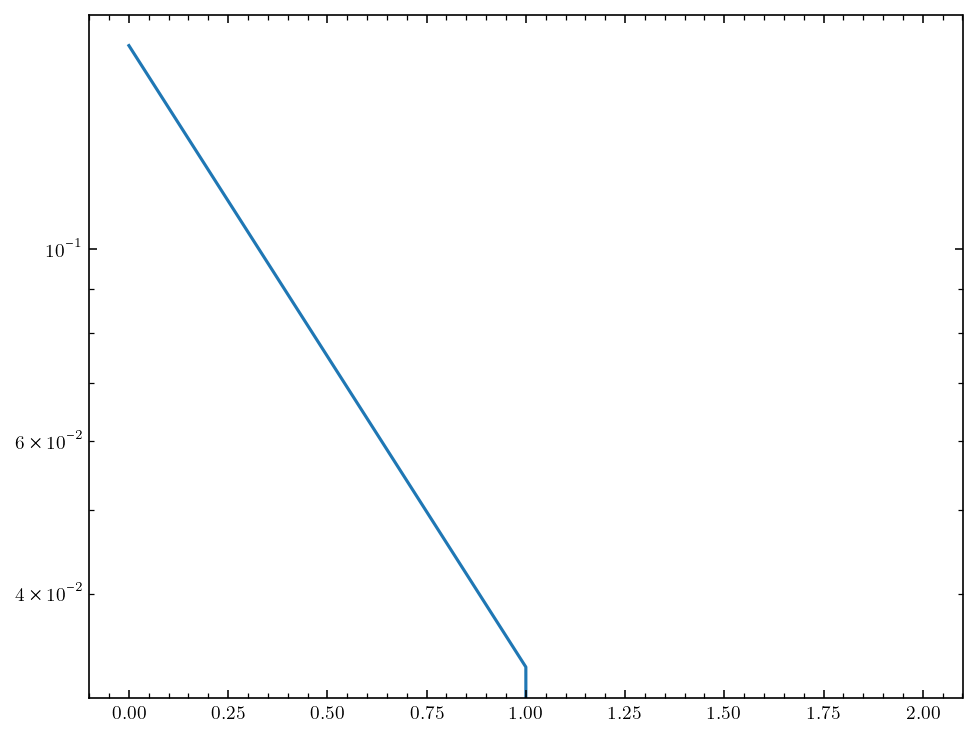

In [ ]:
U, S, Vh = np.linalg.svd(potential.evalAffine(grid.points))
plt.plot(S)
plt.yscale('log')

In [ ]:
S

array([0.17206347, 0.03290525, 0.        ])

In [ ]:
fig.savefig("benchmark.pdf")

In [ ]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
lvalues = [0, 1, 2, 5, 12]
channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 

inhomogeneous=False
E_MeV = 50
# generate training data
rmatch = 12
# rmin = np.min((0.1, (factorial2(2*l+1) * 1e-4)**(1/(l+1)) / scattExp.p))
rmin = 1e-12
assert rmin < 1, "rmin > 1"
# print(f"rmin: {rmin}")
fig, axs = plt.subplots(1,2, figsize=(4,3))
ax = axs[0]
for channel in channels:
    l = channel.L
    potential = Potential(channel, **potentialArgs)
    trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

    scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

    grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
                type="linear", test=False) 
    scattSols_numerov = RseSolver.solve(scattExp, grid, testingLecList, 
                                method="Numerov", inhomogeneous=inhomogeneous,
                                asympParam="K", matching=True)
    scattSols_rk45 = RseSolver.solve(scattExp, grid, testingLecList, 
                                method="RK45", inhomogeneous=inhomogeneous,
                                asympParam="K", matching=True)
    
    pr = grid.points * scattExp.p

    ax.plot(grid.points, 
             np.abs(scattSols_numerov[0].u-scattSols_rk45[0].u), label=f"${l}$")
    ax.set_yscale('log')
    ax.set_xlabel("$r$")
    ax.set_ylabel("$y(r)$")
    # plt.title(f"$\ell = {l}$")
    ax.legend(title="$\ell =$")
    ax.set_ylim(1e-15, 1e-9)

    a = scattSols_numerov[0].Lmatrix.phaseShift
    b = scattSols_rk45[0].Lmatrix.phaseShift
    print("phaseshifts", a,b, np.abs(a-b))

phaseshifts (16.827888002154175+0j) (16.82788793764578+0j) 6.450839507010642e-08
phaseshifts (23.099791966550864+0j) (23.09979191524898+0j) 5.130188540647396e-08
phaseshifts (7.29848683244337+0j) (7.298486804959089+0j) 2.748428062915309e-08
phaseshifts (0.020253451228562494+0j) (0.020253441817417707+0j) 9.411144787085934e-09
phaseshifts (-4.391815853997123e-10+0j) (1.6056688739621069e-10+0j) 5.997484727959229e-10


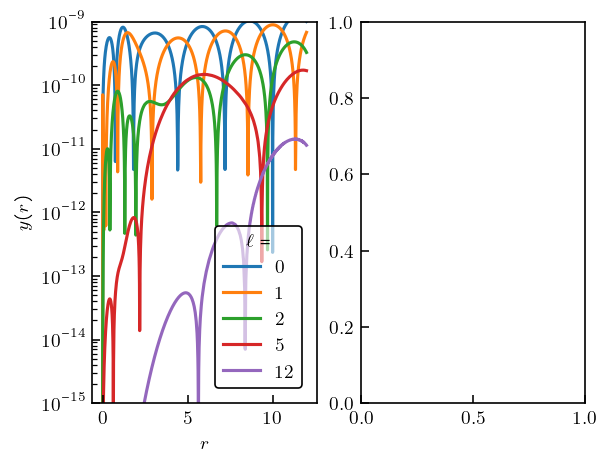

In [ ]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
lvalues = [0, 1, 2, 5, 12]
channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 

inhomogeneous=False
E_MeV = 50
# generate training data
rmatch = 12
# rmin = np.min((0.1, (factorial2(2*l+1) * 1e-4)**(1/(l+1)) / scattExp.p))
rmin = 1e-12
assert rmin < 1, "rmin > 1"
# print(f"rmin: {rmin}")
fig, axs = plt.subplots(1,2, figsize=(4,3))
ax = axs[0]
for channel in channels:
    l = channel.L
    potential = Potential(channel, **potentialArgs)
    trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

    scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

    grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
                type="linear", test=False) 
    scattSols_numerov = RseSolver.solve(scattExp, grid, testingLecList, 
                                method="Numerov", inhomogeneous=inhomogeneous,
                                asympParam="K", matching=True)
    scattSols_rk45 = RseSolver.solve(scattExp, grid, testingLecList, 
                                method="RK45", inhomogeneous=inhomogeneous,
                                asympParam="K", matching=True)
    
    pr = grid.points * scattExp.p

    ax.plot(grid.points, 
             np.abs(scattSols_numerov[0].u-scattSols_rk45[0].u), label=f"${l}$")
    ax.set_yscale('log')
    ax.set_xlabel("$r$")
    ax.set_ylabel("$y(r)$")
    # plt.title(f"$\ell = {l}$")
    ax.legend(title="$\ell =$")
    ax.set_ylim(1e-15, 1e-9)

    a = scattSols_numerov[0].Lmatrix.phaseShift
    b = scattSols_rk45[0].Lmatrix.phaseShift
    print("phaseshifts", a,b, np.abs(a-b))

## Notes on Numerov's method

We aim to solve the special second-order differential equations

$$
\frac{d^2 y}{dx^2} = f(x,y), \quad \mathrm{with} \quad y(a) = y_0 \quad \mathrm{and} \quad y(a) = y'_0
$$

[Numerov's method](https://en.wikipedia.org/wiki/Numerov%27s_method) gives the following recurrence relation

$$ 
y_{n+1} - 2 y_n + y_{n-1} = \frac{h^2}{12} (f_{n+1} + 10 f_n + f_{n-1}) + \mathcal{O} (h^6)\,.
$$
It achieves order-4 accuracy. This is an implicit linear multistep method, which reduces to the explicit method given above if $f$ is linear in $y $ by setting 

$$ f(x,y) = - g(x) y(x) + s(x)\,.$$ 

In that case, the differential equation takes on this form:
$$
 \frac{d^2 y}{dx^2} = - g(x) y(x) + s(x).
$$
The three values of $ y_{n-1}, y_n, y_{n+1} $ taken at three equidistant points $ x_{n-1}, x_n, x_{n+1} $ are related as follows:

$$
y_{n+1} \left(1 + \frac{h^2}{12} g_{n+1}\right) = 2 y_n \left(1 - \frac{5 h^2}{12} g_n\right) - y_{n-1} \left(1 + \frac{h^2}{12} g_{n-1}\right) + \frac{h^2}{12} (s_{n+1} + 10 s_n + s_{n-1}) + \mathcal{O}(h^6),
$$
where $y_n = y(x_n)$, $g_n = g(x_n) $, $ s_n = s(x_n) $, and $ h = x_{n+1} - x_n $.

Let's define

$$
K_n(\xi) = 1 + \xi \frac{h^2}{12} g_{n}
$$

and then rewrite Numerov's relation for $n \geq 1$:

$$ \boxed{
y_{n+1} K_{n+1}(1) - 2 y_n K_{n}(-5) + y_{n-1}K_{n-1}(1) = \frac{h^2}{12} (s_{n+1} + 10 s_n + s_{n-1})}
$$

Given $y_0$ and $y_1$, we can express this relation as the linear system (i.e., matrix equation) $\mathbf{A} \vec{y} = \vec{s}$, with $\vec{y} = (y_0, y_1, y_2, \ldots, y_N)$ and

$$
\mathbf{A} = 
\begin{bmatrix}
    1      &            &            &            &        &              &                &    \\
    0      &  1         &            &            &        &              &                &    \\
    K_0(1) & -2 K_1(-5) & K_2(1)     &            &        &              &                &    \\ 
           & K_1(1)     & -2 K_2(-5) & K_3(1)     &        &              &                &   \\ 
           &            & K_2(1)     & -2 K_3(-5) & K_4(1) &              &                &  \\ 
           &            &            &            & \ddots &              &                &   \\
           &            &            &            &        &  K_{N-2}(1)  & -2 K_{N-1}(-5) & K_N(1)  \\
    \end{bmatrix}
$$

$$
\vec{s} = 
\begin{bmatrix}
y_0\\
y_1\\
\frac{h^2}{12} (s_2 + 10 s_1 + s_0)\\
\frac{h^2}{12} (s_3 + 10 s_2 + s_1)\\
\vdots\\
\frac{h^2}{12} (s_N + 10 s_{N-1} + s_{N-2})
\end{bmatrix}
$$

Note that this matrix is a (lower) triangular band matrix ($N+1 \times N+1$). It has non-zero lower and upper diagonals, $l=2$ and $u=0$, and thus the bandwith $B = l + u + 1 = 3$, which is independent of $N$. It can be efficiently solved using `scipy.linalg.solve_banded`. But it might actually be fast to solve this system using `scipy.linalg.solve_triangular`.


It might make sense to reduce the dimension of the matrix by explicity setting $y_0$ and, if possible (see below), $y_1$. The result is, for the above case, the system $\mathbf{\tilde{A}} \vec{\tilde{y}} = \vec{\tilde{s}}$, with the ($N-1 \times N-1$) matrix: 

\begin{align}
\mathbf{\tilde{A}} &= 
\begin{bmatrix}
        K_2(1) &  &  &   &   & & &   \\ 
            -2 K_2(-5) & K_3(1) &   &   & & &   \\ 
                K_2(1) & -2 K_3(-5) & K_4(1) & & & & & \\ 
                &   & \ddots &  & & & &   \\
                &   &   &   &   &  K_{N-2}(1)  & -2 K_{N-1}(-5) & K_N(1)  \\
    \end{bmatrix}\\
\vec{\tilde{s}} &= 
\begin{bmatrix}
\frac{h^2}{12} (s_2 + 10 s_1 + s_0) - K_0(1)y_0 + 2 K_1(-5) y_1\\
\frac{h^2}{12} (s_3 + 10 s_2 + s_1) - K_1(1)y_1 \\
\vdots\\
\frac{h^2}{12} (s_N + 10 s_{N-1} + s_{N-2})
\end{bmatrix}
\end{align}
and $\vec{\tilde{y}} = (y_2, \ldots, y_N)$. This (reduced) matrix has the same $(l,u, B)$ as before. 

How to determine $y_1$ to start Numerov's method? We will discuss this important question in the next section.

## Initial conditions: Gonzalez et al.

As noted, e.g., by [Adee et al.](https://pubs.aip.org/aip/cip/article-abstract/11/5/514/136525/Getting-started-with-Numerov-s-method?redirectedFrom=fulltext), starting the Numerov method accurately has important consequence on the global error of the general algorithm. [Gonzalez and Thompson](https://www.sciencedirect.com/science/article/pii/S0377042704002559) derived the following starting formula:

$$\boxed{
y_1 = y_0 + h y'_0 + \frac{h^2}{24} (7f_0 + 6f_1 − f_2) ,}
$$

where $y_0$ and $y'_0$ are given by initial values.
Again, in our case $f(x,y)$ is a linear function, so we find in this special case:

$$
y_1 \underbrace{\left( 1 + \frac{6h^2}{24} g_1 \right)}_{=K_1(3)} - \underbrace{\frac{h^2}{24} g_2}_{=K_2(\frac{1}{2})-1}y_2 = y_0 \underbrace{\left( 1- \frac{7h^2}{24} g_0 \right)}_{=K_0(-\frac{7}{2})}  + h y'_0 + \frac{h^2}{24} \left( 7s_0 + 6 s_1 - s_2 \right) 
$$




This can be cast into this $(N \times N)$ linear system:
$$
\mathbf{A} = 
\begin{bmatrix}
       K_1(3) & 1-K_2(\frac{1}{2}) &  &  &   &   & & &   \\
       -2 K_1(-5) & K_2(1) &  0 &  &   &   & & &   \\ 
           K_1(1) & -2 K_2(-5) & K_3(1) & 0  &   & & &   \\ 
               0 & K_2(1) & -2 K_3(-5) & K_4(1) & & & & & \\ 
             &   &   & \ddots &  & & & &   \\
             &   &   &   &   &   &  K_{N-2}(1)  & -2 K_{N-1}(-5) & K_N(1)  \\
    \end{bmatrix}
$$

$$
\vec{s} = 
\begin{bmatrix}
y_0 K_0(-\frac{7}{2})  + h y'_0 + \frac{h^2}{24} \left( 7s_0 + 6 s_1 - s_2 \right) \\
-y_0 K_0(1)  + \frac{h^2}{12} (s_2 + 10 s_1 + s_0)\\
\frac{h^2}{12} (s_3 + 10 s_2 + s_1)\\
\vdots\\
\frac{h^2}{12} (s_N + 10 s_{N-1} + s_{N-2})
\end{bmatrix}
$$

and $\vec{\tilde{y}} = (y_1, \ldots, y_N)$. This matrix is tridiagonal and has $l= 2$, $u=1$, thus $B=4$.

Note that the first $2 \times 2$ block in the matrix corresponds to Eq. (12) through (14) in [Gonzales and Thompson](https://pubs.aip.org/aip/cip/article-abstract/11/5/514/136525/Getting-started-with-Numerov-s-method?redirectedFrom=fulltext). 

It's important to check that the implementation of the initial values does not render the matrix singular. The first $2\times 2$ block of the matrix reads:

$$
\det 
\begin{bmatrix}
 K_1(3) & 1-K_2(\frac{1}{2})\\
 -2 K_1(-5) & K_2(1)
\end{bmatrix}
\xrightarrow{h \to 0 }
\det
\begin{bmatrix}
 1 & 0\\
 -2 & 1
\end{bmatrix}
= 1 \neq 0 
$$

The other rows in the matrix have non-zero components in at least $y_3$ (or high index).

The authors also note that in Eq. (15) that the solution is:

$$
y_1 = \frac{K_2(1) b_1 - (1-K_2(1/2)) b_2}{K_1(3) K_2(1) + 2 K_1(-5) (1-K_2(1/2) }
$$

with $b_1$ and $b_2$ being the first two entries in the vector $\vec{s}$ above. Hence, we can cast the problem into the $(N-1 \times N-1)$ linear system:
$$
\mathbf{A} = 
\begin{bmatrix}
       K_2(1) &  0 &  &   &   & & &   \\ 
            -2 K_2(-5) & K_3(1) & 0  &   & & &   \\ 
                K_2(1) & -2 K_3(-5) & K_4(1) & & & & & \\ 
               &   & \ddots &  & & & &   \\
               &   &   &   &   &  K_{N-2}(1)  & -2 K_{N-1}(-5) & K_N(1)  \\
    \end{bmatrix}
$$

$$
\vec{s} = 
\begin{bmatrix}
-y_0 K_0(1) + 2 K_1(-5) y_1 + \frac{h^2}{12} (s_2 + 10 s_1 + s_0)\\
- K_1(1) y_1 + \frac{h^2}{12} (s_3 + 10 s_2 + s_1)\\
\vdots\\
\frac{h^2}{12} (s_N + 10 s_{N-1} + s_{N-2})
\end{bmatrix}
$$

and $\vec{\tilde{y}} = (y_2, \ldots, y_N)$. This matrix is lower (banded) triangular and has $l= 2$, $u=0$, thus $B=3$.

## Implementation

In this subsection, we discuss the steps of the Numerov method in our implementation. We discuss both the general and the affine case.

### Initial condition for Numerov's method

We follow Gonzalez et al. and determine $y_1$ using the initial value on the derivative by solving the system:
$$
\underbrace{
\begin{bmatrix}
 K_1(3) & 1-K_2(\frac{1}{2})\\
 -2 K_1(-5) & K_2(1)
\end{bmatrix}
}_{=A_2}
\begin{bmatrix}
 y_1\\
 y_2
\end{bmatrix}
= 
\underbrace{
\begin{bmatrix}
y_0 K_0(-\frac{7}{2})  + h y'_0 + \frac{h^2}{24} \left( 7s_0 + 6 s_1 - s_2 \right) \\
-y_0 K_0(1)  + \frac{h^2}{12} (s_2 + 10 s_1 + s_0)\\
\end{bmatrix}
}_{=b_2}
$$

Note that this also gives us $y_2$. Let's assume $g(x)$ and $(x)$ have (continiuous) affine parameter dependences (e.g., that could be the energy $E$):

\begin{align}
g(x) = \sum_{i=0} \theta_i \, g^{(i)}(x)
\end{align}

and similarly for $s(x)$. Then, we can write this $2\times 2$ system as:

\begin{align}
A_2 = 
\begin{bmatrix}
 1 & 0\\
 -2  & 1
\end{bmatrix}
+ \frac{h^2}{24} 
\underbrace{\left(
\begin{bmatrix}
 6 & -1\\
 20  & 2
\end{bmatrix}_{ij}
\begin{bmatrix}
g_1^{(k)} \\  g_2^{(k)}
\end{bmatrix}_{jk}
\right)}_{=\mathcal{T}_{ijk}}
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}
\end{align}

Note that the term in the parenthesis is a rank-3 tensor (check notation!). The decomposition through multiplying by a diagonal matrix is optional. Furthermore: 

\begin{align}
b_2 = 
\begin{bmatrix}
y_0 + h y'_0  \\
-y_0 \\
\end{bmatrix}
+
 \frac{h^2}{24}
\left(
-
y_0
\begin{bmatrix}
7 \\
2  \\
\end{bmatrix}
\begin{bmatrix}
g_0^{(0)} & g_0^{(1)} \cdots
\end{bmatrix}
+
\begin{bmatrix}
 7 & 6 & - 1  \\
 2 & 20 & 2 \\
\end{bmatrix}
\begin{bmatrix}
s_0^{(0)} & s_0^{(1)} & \cdots\\
s_1^{(0)} & s_1^{(1)} & \cdots\\
s_2^{(0)} & s_2^{(1)} & \cdots\\
\end{bmatrix}
\right)
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}
\end{align}

The terms in parenthesis (incl. prefactors) can be prestored. Solving this $2\times 2$ system determins $y_1$ _and_ $y_2$.

### Matrix equation of Numerov's method

Since the previous step already determined $(y_1,y_2)$ (and $y_0$ has an initial value), we can cast Numerov's method into the $(N-2 \times N-2)$ linear system:
$$
\mathbf{A} = 
\begin{bmatrix}
       K_3(1) &  0 &  &   &   & & &   \\ 
        -2 K_3(-5) & K_4(1) & 0  &   & & &   \\ 
            K_3(1) & -2 K_4(-5) & K_5(1) & & & & & \\ 
            &   & \ddots &  & & & &   \\
            &   &   &   &   &  K_{N-2}(1)  & -2 K_{N-1}(-5) & K_N(1)  \\
    \end{bmatrix}
$$

$$
\vec{s} = 
\begin{bmatrix}
- K_1(1) y_1 + 2K_2(-5) y_2 + \frac{h^2}{12} (s_3 + 10 s_2 + s_1)\\
- K_2(1) y_2 + \frac{h^2}{12} (s_4 + 10 s_3 + s_2)\\
\vdots\\
\frac{h^2}{12} (s_N + 10 s_{N-1} + s_{N-2})
\end{bmatrix}
$$

and $\vec{\tilde{y}} = (y_3, \ldots, y_N)$. This matrix is lower (banded) triangular and has $l= 2$, $u=0$, thus $B=3$, as before.

Now, we take advantage of the affine decompositions of $g(x)$ and $s(x)$. Let's consider the matrix first. We can write the matrix in diagonal ordered form, which is the input for `np.linalg.solve_banded()`, as follows:

$$
\begin{bmatrix} 
K_3(1) & K_4(1) & \cdots & K_{N-1}(1) & K_N(1)\\
-2K_3(-5) & -2K_4(-5) & \cdots & -2K_{N-1}(-5) & *\\
K_3(1) & K_4(1) & \cdots & * & *\\
\end{bmatrix}_{ij}
= 
\underbrace{
\begin{bmatrix}
1 \\ -2 \\ 1
\end{bmatrix}
\begin{bmatrix}
1 & 1 & \cdots
\end{bmatrix}}_{=B\times N-2}
+ \frac{h^2}{12}
\sum_k
\underbrace{
\left(
\begin{bmatrix} 
1\\10\\1
\end{bmatrix}_i
\begin{bmatrix}
g_3^{(0)} & g_3^{(1)} & g_3^{(2)} & \cdots \\
g_4^{(0)} & g_4^{(1)} & g_4^{(2)} & \cdots \\
g_5^{(0)} & g_5^{(1)} & g_5^{(2)} & \cdots \\ 
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}_{jk}
\right)
}_{=\mathcal{T}_{ijk}}
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}_k
$$

The values marked by $*$ are abitrary. For simplicity, we set them explictly, but we could set them to zero as a (simple) postprocessing step. Again, the terms in parenthesis can be prestored (e.g., using `np.einsum()`). See [Common operations in this notation](https://en.wikipedia.org/wiki/Einstein_notation#Common_operations_in_this_notation) as a refresher on the Einstein sum convention.

Next, we decompose the right-hand side vector:

\begin{align}
\vec{s} = 
\begin{bmatrix}
- y_1 + 2y_2 \\
- y_2 \\
0\\
\vdots
\end{bmatrix}
+
 \frac{h^2}{12}
\begin{bmatrix}
- y_1 & -10y_2  \\
0 & - y_2 \\
0 & 0\\
\vdots & \vdots
\end{bmatrix}
\begin{bmatrix}
g_1^{(0)} & g_1^{(1)} & g_1^{(2)} & \cdots \\
g_2^{(0)} & g_2^{(1)} & g_2^{(2)} & \cdots 
\end{bmatrix}
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}
+
 \frac{h^2}{12}
 \underbrace{
\begin{bmatrix}
1 & 10 & 1 & & & \\
& 1 & 10 & 1 & & \\
&   &    &   & \ddots&
\end{bmatrix}
}_{(N-2) \times N}
\begin{bmatrix}
s_1^{(0)} & s_1^{(1)} & s_1^{(2)} & \cdots \\
s_2^{(0)} & s_2^{(1)} & s_2^{(2)} & \cdots \\
s_3^{(0)} & s_3^{(1)} & s_3^{(2)} & \cdots \\ 
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}
\end{align}

This equation can be cast into the form: $\vec{s} = \vec{s}_0 (y_1,y_2) + S (y_1,y_2)\vec{\theta}$, where only the first two components of $\vec{s}_0$ are non-zero so that not the entire vector needs to be added to the second term. Alternatively, one could also use this form: $\vec{s} = \left(\vec{s}_0 (y_1,y_2) + S\right)\vec{\theta}$.

### Emulator equations

For the left-hand side of the emulator equation, we need to carry out the reduction and projection, $X^\intercal A X
$. To this end, we need the full matrix $\mathbf{A}$ rather than its diagonal ordered form (see above):

$$
\mathbf{A} = 
\begin{bmatrix}
    1 &  0 &  &   &   & & &   \\ 
    -2  & 1 & 0  &   & & &   \\ 
        1 & -2  & 1 & & & & & \\ 
        &   & \ddots &  & & & &   \\
        &   &   &   &   &  1  & -2  & 1
\end{bmatrix}
+
\frac{h^2}{12}
\sum_k
\underbrace{
    \left(
\begin{bmatrix}
1 &  0 &  &   &   & & &   \\ 
10 & 1 & 0  &   & & &   \\ 
1 & 10 & 1 & & & & & \\ 
    &   & \ddots &  & & & &   \\
    &   &   &   &   &  1  & 10 & 1 
\end{bmatrix}_{ij}

\begin{bmatrix}
g_3^{(0)} & g_3^{(1)} & g_3^{(2)} & \cdots \\
g_4^{(0)} & g_4^{(1)} & g_4^{(2)} & \cdots \\
g_5^{(0)} & g_5^{(1)} & g_5^{(2)} & \cdots \\ 
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}_{jk}
\right)
}_{\mathcal{=T_{ijk}}}
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}_k
$$

The matrix decomposition in terms of a diagonal matrix is optional. Hence, we can write $\mathbf{A}_{ij} = (\mathbf{A}_0)_{ij} + (\sum_k \mathcal{T}_{ijk} \theta_k)_{ij}$. 

The result of $X^\intercal A X$ has two terms:

* The first term is straightforward to evaluate since it involves the constant piece of $\mathbf{A}$.
* The second term involves a rank-3 tensor. We can write the components of the result as:

\begin{align}
(X^\dagger A X)_{ij} &=  (X^\dagger A_0 X)_{ij} + \sum \limits_{mlk} (X^\dagger)_{im} \mathcal{T}_{mlk} \theta_k X_{lj}\\
&= (X^\dagger A_0 X)_{ij} +\sum_k \left[\sum \limits_{ml} X_{mi}^* \mathcal{T}_{mlk} X_{lj}\right]_{ijk} \theta_k
\end{align}

Again, we use `np.einsum()` for tensor contractions (using Einstein sum convention).

For the right-hand side of the emulator equation, we need to carry out the projection $X^\intercal \vec{s}$. This is straightforward as each of the matrices in $\vec{s}$ (see above) just needs to be left multiplied by $X^\intercal$.

Note that the emulator prediction for $(y_0,y_1,y_2)$ are guaranteed to match those of the FOM. Hence, the emulated results will always abide by the initial conditions. This is good and bad news at the same time. 

The **good news** is that accurate initial conditions is crucial for overall accurate results. Also the reduced order model is supposed to live in the subspace where the initial conditions are fulfilled in the chosen approximation.

<font color=red> <b>
The bad news is that we can prestore less. But that's ok because what we can't prestore lives in a two-dimensional space, only affecting the first two components of the emulator equations.
</b> </font>

### Error estimates

#### Prestoring the error (scalar)

Let's discuss error estimates: We define the residual (in the full space)

$$
R = A \tilde{x} - s
$$

with $\tilde{x} = X \vec{\theta}$ being the solution in the reduced space. For high-fidelty calculations one has $R\equiv 0$. We seek after an error estimate that can be computed in the reduced space. One approach is decomposing the error as follows:

\begin{align}
\epsilon^2 \equiv R^\dagger R &= (A \tilde{x} - s)^\dagger (A \tilde{x} - s)\\
&= \tilde{x}^\dagger A^\dagger A\tilde{x} \\
&\quad - \underbrace{\left[\tilde{x}^\dagger A^\dagger s + (\tilde{x}^\dagger A^\dagger s)^\dagger\right]}_{= 2\operatorname{\mathbb{R}e}(\tilde{x}^\dagger A^\dagger s)}\\
&\quad+ s^\dagger s
\end{align}

One has to be careful with complex-valued problems, where instead of the transpose ($\intercal$) one has the hermitian-conjugate ($\dagger$). One also has to be careful with round off errors, which can render $\epsilon^2 < 0$.

The goal is then to minimze $\epsilon \geq 0$ by placing iteratively snapshots at locations of maximum error in the parameter space of the potential.

One issue is that both $A = A(\theta)$ and $b = b(\theta)$.

Another issue with this formulation is that we still have order-N operations. The solution is use the affine decomposition of the potential, which propagates through $A$ and $b$. The error $\epsilon \geq 0$ should be a polynomial of order of the number of snapshots in each dimension of the parameter space. Newton-Raphson could be used to find the location of maximum error if needed. The gradient with respect to the parameters can be computed analytically. Another option is automatic differentiation together with the Adam optimizer, e.g., as implemented in Google JAX. 

However, the coefficient vector of the ROM also depends nonlinearly on the parameter vector, which makes the optimization more complicated.

**How do we define the break condition for the greedy iteration?** The estimated error is (at best!) approximatively proportional to the real error. 

To construct an efficient error estimator in the online stage, we prestore all projections in form a tensors in the offline stage. This can be done as described in the following.

Let's recall: we can write $\vec{s} = \vec{s}_0 + S \vec{\theta}$, $A_{ij} = (A_0)_{ij} + (\sum_k \mathcal{T}_{ijk} \theta_k)_{ij}$, and $\tilde{x} = X c$. Note that the coefficient vector $c = c(\theta)$.

Hence, we find for these scalar terms the following.

The **first term** evaluates to:

\begin{align}
\tilde{x}^\dagger A^\dagger A\tilde{x} &= c^\dagger X^\dagger (A^\dagger A) X c\\
\left(X^\dagger A^\dagger A X\right)_{ij} &= \left(X^\dagger A_0^\dagger A_0 X \right)_{ij} 
+ \left((X^\dagger)_{ik} (A_0^\dagger)_{kl} \mathcal{T}_{lma} \theta_a X_{mj}\right)_{ij}
+ \left((X^\dagger)_{ik} \mathcal{T}_{lka}^* \theta_a^* (A_0)_{lm} X_{mj}\right)_{ij} 
+ \left((X^\dagger)_{ik} \mathcal{T}_{lka}^* \theta_a^* \mathcal{T}_{lmb} \theta_b X_{mj}\right)_{ij}  \\
&= \left( X^\dagger A_0^\dagger A_0 X \right)_{ij} 
+ \left[ \sum_a \left( \sum_{klm} (X^\dagger)_{ik} (A_0^\dagger)_{kl} \mathcal{T}_{lma}  X_{mj}\right)_{ija}  \theta_a + \mathrm{h.c.} \right]_{ij}
+ \sum_{ab} \left( \sum_{klm} (X^\dagger)_{ik} \mathcal{T}_{lka}^*  \mathcal{T}_{lmb} X_{mj}\right)_{ijab} \theta_a^* \theta_b
\end{align}

The rank-4 tensor has the shape $(n_s^2 \times n_\theta^2)$, where $n_s$ is the number of snapshots and $n_\theta$ the number of free parameters. For $(n_s=20, n_\theta=25)$, one thus has $250,000$ (complex-valued) tensor elements to prestore. In memory: $250,000 \times 2 \times 8 \, \mathrm{bytes} = 4\, \mathrm{Mb}$, so not at all a memory issue.

The **second term** evaluates to (for simplicity we evaluate the complex conjugated term):

\begin{align}
(\tilde{s}^\dagger A \tilde{x}) &= \sum \limits_{ijk}\left( s_0^\dagger + \theta^\dagger S^\dagger  \right)_{k} \left(A_0 + \sum \mathcal{T}_{kia} \theta_a \right)_{ki} X_{ij} c_{j}\\
&= (s_0^\dagger)_k (A_0)_{ki}  X_{ij} c_{j} 
+ (s_0^\dagger)_k \sum_a \mathcal{T}_{kia} \theta_a   X_{ij} c_{j}
+ \sum_b (S^\dagger)_{bk} \theta_b^* (A_0)_{ki} X_{ij} c_{j}
+ \sum_{ab} (S^\dagger)_{bk} \theta_b^* \mathcal{T}_{kia} \theta_a  X_{ij} c_{j}\\
&= (s_0^\dagger)_i \left[ \sum_l (A_0)_{il} X_{lj} \right]_{ij} c_{j} 
+ (s_0^\dagger)_k \sum_{aj} \left[ \sum_{i} \mathcal{T}_{kia}   X_{ij}  \right]_{ajk} \theta_a  c_{j}
+  \sum_{jb} \left[ \sum_{ik}  (S^\dagger)_{bk}  (A_0)_{ki}  X_{ij}  \right]_{bj} c_{j} \theta_b^*
+  \sum_{abj} \left[ \sum_{ik} (S^\dagger)_{bk} \mathcal{T}_{kia}   X_{ij} \right]_{baj} \theta_a \theta_b^* c_{j}
\end{align}

In the last step, we used that the parameter vector is real in our cases, so $\theta^* = \theta$. The terms in brackets can be prestored. Tensor reduction using `np.einsum`.

**Note that $s_0 = s_0(\theta)$, so it cannot be prestored. However, it's just a length-2 vector.**

The **third term** evaluates to:

\begin{align}
s^\dagger s &= s_0^\dagger s_0 + s_0^\dagger S \vec{\theta} + (s_0^\dagger S \vec{\theta})^\dagger + \vec{\theta}^\dagger S^\dagger S \vec{\theta}\\
&= s_0^\dagger s_0 + 2\operatorname{\mathbb{R}e} \left( s_0^\dagger S \vec{\theta} \right) + \vec{\theta}^\dagger S^\dagger S \vec{\theta}
\end{align}

Again, the two terms involving $s_0 = s_0(\theta)$ can only be partially prestored. 

#### Prestoring the residual vector

As already noted, one also has to be careful with round off errors, which can render $\epsilon^2 < 0$. To avoid those issues, we can reconstruct the residual vector and then compute any (desired) norm of the residual vector. This guarantees that $\epsilon^2 \geq 0$. 

Let's assume an affine parameter dependence for our linear system $A(\vec{\theta}) x = b(\vec{\theta}) $, where $A(\vec{\theta})$ is an $N \times N$ matrix and $b(\vec{\theta})$ a length-$N$ vector:

\begin{align}  
A(\vec{\theta}) &= \sum_{i}^{n_\theta} A_i \theta_i \\  
b(\vec{\theta}) &= \sum_{i}^{n_\theta} b_i \theta_i  
\end{align}  

Next, we write high-fidelity solutions in a matrix form, where $X$ (a $N \times n_b$ matrix) has the snapshot solutions in its columns. Then, we consider the residual for our reduced-basis approximation $x \approx X \vec{c}$, where $c$ is the coefficient vector:

\begin{align}  
R(\theta) &= A(\vec{\theta})  X \vec{c} - b(\vec{\theta}) \\
&= \sum_{i}^{n_\theta} \left[ A_i X \vec{c} - b_i \right] \vec{\theta}_i
\end{align}  

We are interested in $\varepsilon^2 = R^\dagger(\vec{\theta}) R(\vec{\theta}) \geqslant 0$. We can see that this residual $R(\theta)$ lives in the vector space spanned by the columns of all $A_i X$ and all vectors $b_i$. Hence, we compute the (matrix) components:
  
$$  
B_i = A_i X \quad \forall i \; \mathrm{separately}
$$  
  
Now, we create a block matrix from all $B_i$ (i.e., $N \times n_b$ matrices) by stacking them horizontally. In `numpy`, this can be done using the `hstack()` function. In addition, we stack the vectors $b_i$ to obtain the $N \times n_\theta(n_b+1)$ matrix.

$$
Y = \begin{bmatrix} B_1 & B_2 & \cdots & B_{n_\theta} & b_1 & b_2 & \cdots & b_{n_\theta}\end{bmatrix}
$$

Next, we orthnonormalize the vectors in the columns of $Y$, which contain the projection basis. This could be done using the modified Gram-Schmidt process, or using the (truncated) SVD. Note that $P = Y Y^\dagger$ has become an **orthogonal projector** onto the space of the residuals $R(\theta)$ for our RBM approximation. This implies the identities:

\begin{align}
P^2 &\equiv P\\
P \, R(\vec{\theta}) &\equiv R(\vec{\theta}) \quad \forall \vec{\theta}, \vec{c}\\
P^\dagger &\equiv P
\end{align}

Note that this does _not_ imply that $P = 1$ (identity matrix). Let's consider the projected residual vector:
  
\begin{align}  
    r(\vec{\theta}) &\equiv Y^\dagger R(\vec{\theta}) = Y^\dagger A(\vec{\theta}) X \vec{c} (\vec{\theta}) - Y^\dagger b(\vec{\theta})
\end{align}  

It is a length-$n_\theta(n_b+1)$ vector. Hence, it generally does not live in the reduced or full space but instead in an **"intermediate space"**! Truncated SVDs for orthonormalizations help reduce the dimension of this space.

Because $P = Y Y^\dagger$ is a projector (note that $X X^\dagger$ generally is _not_ an orthogonal projector onto the space of the residuals), we find that:

$$
r^\dagger(\theta) r(\theta) = R^\dagger(\theta) \underbrace{Y Y^\dagger R(\theta)}_{=R(\theta)} =  R^\dagger(\theta) R(\theta) \equiv \epsilon^2 
$$

That means the norms of the residual vector in the full and in the projected space are equivalent. Using the affine decomposition, the residual vector can be efficiently prestored:

\begin{align}
    r(\theta) &= Y^\dagger A(\theta) X c(\theta) - Y^\dagger b(\theta) \\
              &= \sum_{a}^{n_\theta} \left[ Y^\dagger A_a X \right] \,  c(\theta) \theta_k - \sum_{a}^{n_\theta} \left[Y^\dagger  b_a\right] \theta_a \\
  r_i(\theta) &= \sum_{al}  \underbrace{\sum_{jk} (Y^\dagger)_{ij} A_a^{(jk)} X_{kl}}_{=\mathcal{T}_{ial}} \,  c_l(\theta) \theta_a - \sum_{a} \underbrace{\sum_{j} (Y^\dagger)_{ij}  b_a^{(j)}}_{=\mathcal{T}_{ia}} \theta_a
\end{align}

#### Alternative emulator: Least-Squares Petrov-Galerkin projection
  
Instead of left-multiplying by $X^\dagger$, the linear system, one can multiply by $Y^\dagger$. This corresponds to the **Petrov-Galerkin projection**:

$$
\underbrace{Y^\dagger A(\theta) X}_{= (n_\theta(n_b+1)) \times n_b \, \mathrm{matrix}} c(\theta) = Y^\dagger b(\theta)  
$$

and then solve the reduced equations for $c(\theta)$ using a least-squares solver. This emulator minimizes the residual (i.e., the error) and is known in the literature as **Least-Squares Petrov-Galerkin (LSPG) ROM**. We can use the affine decomposition as follows:

\begin{align}
Y^\dagger A(\theta) X &= \sum_{i}^{n_\theta} Y^\dagger \underbrace{A_i X}_{=B_i} \theta_i \\
&= \sum_{i}^{n_\theta} \left[ Y^\dagger B_i \right] \theta_i 
\end{align}

This allows us to prestore the terms $Y^\dagger B_i$, for all $i$, in the offline stage, and then reconstruct the entire matrix efficiently in the online stage. 

Note that `scipy.linalg.lstsq()` supports multiple methods as opposed to the corresponding `numpy` implementation. **Both implementations return the needed residual vector $r(\theta)$**, so there is no need to compute it for the given the coefficient vector $\vec{c}$ following the approach discussed in the previous subsection. (For more details on solving the least-squares problem using the $QR$ decomposition, see, e.g., [here](https://www.math.kent.edu/~reichel/courses/intr.num.comp.1/fall09/lecture4/lecture4.pdf).)

This Petrov-Galerkin project can be understood differently (by building an emulator for the symmetric positive-definite (s.p.d.) matrix $A^\dagger A$ instead of $A$):

\begin{align}
A(\theta) Xc(\theta) &= b(\theta) \\
\underbrace{A^\dagger(\theta) A(\theta)}_{=\mathrm{s.p.d.\ matrix}} Xc(\theta) &= A^\dagger(\theta)b(\theta) \qquad \mathrm{(normal\ equation)} \\
\underbrace{\left[X^\dagger A^\dagger(\theta) A(\theta)X \right]}_{=\mathrm{s.p.d.\ matrix}} \, c(\theta) &= X^\dagger A^\dagger(\theta)b(\theta) \\
\end{align}

Here, $X^\dagger A^\dagger(\theta)$ corresponds to the Petrov-Galerkin projection. This system has the same least-squares solution as the one above (in this subsection). It has the advantage that the emulator matrix is s.p.d., which means it is invertible (albeit it may still be poorly conditioned) and thus may be **less susceptible to spurious singularities** (Kohn anomalies). 

Note that the underbraced matrices above are only s.p.d. if $A(\theta)$ is non-singular (which we assume from the beginning) and $X$ has linearly independent columns. Hence, we assume here and in the following that the snapshot matrix $X$ has been POD'ed. (See also page 15 in [here](http://www.seas.ucla.edu/~vandenbe/133A/lectures/ls.pdf).)

We can see that the two systems have the same least-squares solution as follows: We start from the Petrov-Galerkin projection above and left-multiply by the transposed (or daggered) matrix on the left-hand side. This results in the normal equation:

\begin{align}
X^\dagger A^\dagger ( Y  Y^\dagger ) A X c &= X^\dagger A^\dagger  ( Y Y^\dagger ) b \\
X^\dagger A^\dagger ( Y  Y^\dagger ) \underbrace{( A X c - b )}_{=R} &= 0 \\
X^\dagger A^\dagger ( A X c - b ) &= 0 \\
X^\dagger A^\dagger  A X c  = X^\dagger A^\dagger b
\end{align}

We have used that $Y Y^\dagger$ is an orthogonal projector onto the space of the residuals. The final equation is the emulator equation for the matrix $A^\dagger A$, which we wanted to show.

It would be interesting to compare this emulator with our previous emulator in terms of accuracy and speed up. This residual-based emulator is well-suited for greedy algorithm implementations.

#### Theoretical error bounds

One can derive **theoretical bounds** on the true error $|(\tilde{x}-x)|$ based on our estimate $\epsilon = |R|$ in the full space. These bounds are determine by the smallest and largest singular vector of the Numerov matrix $A$.

**Lower bound:**
$$
\epsilon = |A x - s| = | A(\tilde{x}-x)| \leq \underbrace{|A|}_{=\sigma_\mathrm{max}} |(\tilde{x}-x)| 
\Longleftrightarrow \frac{\epsilon}{\sigma_\mathrm{max}} \leq  |(\tilde{x}-x)|
$$

**Upper bound:**
$$
|\tilde{x}-x| = |A^{-1} R| \leq \underbrace{|A^{-1}|}_{=\sigma_\mathrm{min}^{-1}} \epsilon
\Longleftrightarrow  |(\tilde{x}-x)| \leq \frac{\epsilon}{\sigma_\mathrm{min}} 
$$

A conservative approach is to use the upper bound as the error estimate. For this approach, the smallest singular value is needed, which can be estimated, e.g., using the [**successive constraint method (SCM)**](https://nam11.safelinks.protection.outlook.com/?url=https%3A%2F%2Fwww.sciencedirect.com%2Fscience%2Farticle%2Fpii%2FS1631073X07003871&data=05%7C02%7Cdrischler%40ohio.edu%7C46350be3c79142903aa708dc316a1338%7Cf3308007477c4a70888934611817c55a%7C0%7C0%7C638439579044877550%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C0%7C%7C%7C&sdata=oaTQUn3EcWSVG%2Bp5Iw0pj7sn2brOg54izlrVZpN4%2B7s%3D&reserved=0). This method can give a lower bound for a new parameter value based on previously computed smallest singular values for other parameter values.

A different approach is the [**hierarchical posteriori error estimation (HPEE)**](https://nam11.safelinks.protection.outlook.com/?url=https%3A%2F%2Flink.springer.com%2Farticle%2F10.1007%2Fs10444-019-09675-z&data=05%7C02%7Cdrischler%40ohio.edu%7C46350be3c79142903aa708dc316a1338%7Cf3308007477c4a70888934611817c55a%7C0%7C0%7C638439579044900640%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C0%7C%7C%7C&sdata=kggKxqTepFj22p0LsYlwMMBcXKMCKPX8YWmbqFq44ho%3D&reserved=0), which computes  errors between different reduced models to estimate the true error. It may be less rigorous than the SCM.

### Schrödinger equation 

Now, let's investigate the radial Schroedinger equation to identify $g(x)$ and $s(x)$. We begin with the **homogeneous** case:

$$ 
\frac{d^2 u(r)}{dr^2} = \left(2\mu V(r) + \frac{l (l + 1)}{r^2} - \underbrace{2\mu E}_{=p^2} \right) u(r)  
$$

Note that we did not introduce an effective potential in the parenthesis. From this equation, we can deduce the function required by our Numerov method:

\begin{align}
g(r) &= p^2 -2\mu V(r) - \frac{l (l + 1)}{r^2} \\
s(r) &= 0
\end{align}

In addition, we have the trivial change of notation: $y(x) = u(r)$. In the affine case, we have:

\begin{align}
g(r) &= \underbrace{p^2 -2\mu V_\mathrm{const}(r) - \frac{l (l + 1)}{r^2}}_{=g_\mathrm{const}(r)} + \sum_a \underbrace{(-2\mu) V_a(r)}_{=g_a(r)} \theta_a \\
s(r) &= 0 \equiv S_\mathrm{const}(r) \equiv S_\theta(r)
\end{align}

Next, we consider the **inhomogeneous** case corresponding to Eq. (48) in the [BUQEYE Guide](https://arxiv.org/abs/2212.04912):

$$
[E - H] \ket{\chi} = V \ket{\phi} 
$$

where $\ket{\chi} = \ket{\psi} - \ket{\phi}$ is the scattered wave function and $\ket{\phi}$ the free wave function. In this case, we have

$$ 
\frac{d^2 \chi(r)}{dr^2} =- \left(p^2 -2\mu V(r) - \frac{l (l + 1)}{r^2} \right) \chi(r) + 2\mu V(r) \phi(r)
$$

Hence, we identify:

\begin{align}
g(r) &= p^2 -2\mu V(r) - \frac{l (l + 1)}{r^2} \\
s(r) &= 2 \mu V(r) \phi(r)
\end{align}

Note that $g(r)$ is the same as for the homogeneous Schroedinger equation (as expected). In the affine case, we have:

\begin{align}
g(r) &= \underbrace{p^2 -2\mu V_\mathrm{const}(r) - \frac{l (l + 1)}{r^2}}_{=g_\mathrm{const}(r)} + \sum_a \underbrace{(-2\mu) V_a(r)}_{=g_a(r)} \theta_a \\
s(r) &= \underbrace{2 \mu V_\mathrm{const}(r) \phi(r)}_{S_\mathrm{const}(r)} + \underbrace{2 \mu V_a  \phi(r)}_{=s_a(r)} \theta_a
\end{align} 

## Simple checks of our Numerov implementation

### Homogeneous case

Let's check the implementation using

$$
\frac{d^2 y}{dx^2} = -y(x), \quad \mathrm{with} \quad y(0) = 0 \quad \mathrm{and} \quad y'(0) = 1
$$

Hence, $g(x) \equiv 1$ and $s(x) \equiv 0$. The solution is 

$$
y(x) = \sin x
$$

Let's solve this ODE:

In [ ]:
from Numerov import *

def g(x, params):
    return 0.*x + 1.

N = 600
xn, h = np.linspace(0, 2*np.pi, N+1, retstep=True)
y0, yp0 = 0, 1
_, _, sol_euler = numerov_euler(xn, y0=y0, yp0=yp0, s=None, g=g)
sol_iter = numerov_iter(xn, y0=y0, yp0=yp0, s=None, g=g)
assert np.allclose(sol_euler, sol_iter, rtol=0, atol=1e-12), "direct iteration and matrix implementation disagree"

# improved initial conditions a la Gonzalez et al.
_, _, sol = numerov(xn, y0=y0, yp0=yp0, s=None, g=g, params=None)

TypeError: 'NoneType' object is not subscriptable

Wo don't expect `sol` and `sol_euler` to match as `sol` should be way more accurate (see below). Let's take a look at runtimes:

In [ ]:
%timeit numerov(xn, y0=y0, yp0=yp0, s=None, g=g)
%timeit numerov_euler(xn, y0=y0, yp0=yp0, s=None, g=g)
%timeit numerov_iter(xn, y0=y0, yp0=yp0, s=None, g=g)

277 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
206 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.22 ms ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The matrix version of Numerov is way faster than the direct iteration version. However, our `numerov` is way slower than `numerov_euler`. This is probabably because of `scipy`'s sparse matrices. It would be way faster if `solve_banded` were used instead.

Next, let's use the affine version of our Numerov solver, `AffineNumerovSolver`. The results have to match our matrix implementation resulting in `sol`.

In [ ]:
num_params = 5
def g_affine(x, params):
    return np.ones((len(x), num_params)) / num_params

g_aff_arr = g_affine(xn, None) @ np.ones(num_params)
g_arr = g(xn, None)
assert np.allclose(g_aff_arr, g_arr, rtol=0, atol=1e-15), "affine and non-affine version of g(x) disagree"

anum = AffineNumerovSolver(xn=xn, g=g_affine, s=None, y0=y0, yp0=yp0, params=None)
_, _, _, sol_affine = anum.solve([np.ones(num_params)])
assert np.allclose(sol_affine, sol, rtol=0, atol=1e-13), "affine and non-affine Numerov solver disagree"

NameError: name 'sol' is not defined

Let's take at the runtime:

In [ ]:
%timeit anum.solve([np.ones(num_params)])

117 µs ± 913 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


`AffineNumerovSolver` is indeed the fastest method!

Next, let's investigate the accuracies. We expect the method implementing Gonzalez et al. equations to be the most accurate--indeed it is!

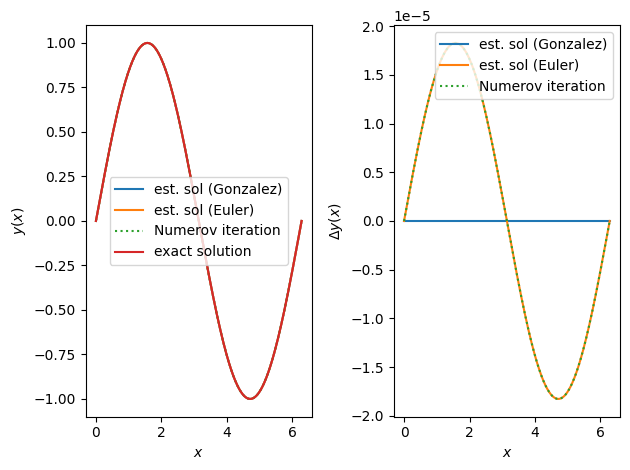

In [ ]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
y_exact = np.sin(xn)
for i, ax in enumerate(axs):
    ax.plot(xn, sol - i*y_exact, label="est. sol (Gonzalez)")
    ax.plot(xn, sol_euler - i*y_exact, label="est. sol (Euler)")
    ax.plot(xn, sol_iter-i*y_exact, ls=":", label="Numerov iteration")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\Delta y(x)$")
    if i == 0:
        ax.plot(xn, y_exact, label="exact solution")
        ax.set_ylabel("$y(x)$")
    ax.legend()

### Inhomogeneous case

Let's check this implementation of the Numerov method using

$$
\frac{d^2 y}{dx^2} = -\sin(x), \quad \mathrm{with} \quad y(0) = 0 \quad \mathrm{and} \quad y'(0) = 1
$$

The solution is 

$$
y(x) \equiv - s(x) = \sin(x) \quad \mathrm{with} \quad g(x) \equiv 0
$$

Let's solve this ODE:

In [ ]:
from Numerov import *

def g(x, params):
    return 0.*x

def s(x, params):
    return - np.sin(x)

N = 600
xn, h = np.linspace(0, 2*np.pi, N+1, retstep=True)
y0, yp0 = 0, 1
_, _, sol_euler = numerov_euler(xn, y0=y0, yp0=yp0, s=s, g=g)
sol_iter = numerov_iter(xn, y0=y0, yp0=yp0, s=s, g=g)
assert np.allclose(sol_euler, sol_iter), "direct iteration and matrix implementation disagree"

# improved initial conditions a la Gonzalez et al.
_, _, sol = numerov(xn, y0=y0, yp0=yp0, s=s, g=g, params=None)

Wo don't expect `sol` and `sol_euler` to match as `sol` should be way more accurate (see below). Let's take a look at runtimes:

In [ ]:
%timeit numerov(xn, y0=y0, yp0=yp0, s=s, g=g)
%timeit numerov_euler(xn, y0=y0, yp0=yp0, s=s, g=g)
%timeit numerov_iter(xn, y0=y0, yp0=yp0, s=s, g=g)

270 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
204 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.7 ms ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


As in the homogeneous case, the matrix version of Numerov is way faster than the direct iteration version. However, our `numerov` is again way slower than `numerov_euler`. This is probabably because of `scipy`'s sparse matrices. It would be way faster if `solve_banded` were used instead.

Next, let's use the affine version of our Numerov solver, `AffineNumerovSolver`. The results have to match our matrix implementation resulting in `sol`.

In [ ]:
num_params = 3
def g_affine(x, params):
    return np.zeros((len(x), num_params)) / num_params

g_aff_arr = g_affine(xn, None) @ np.ones(num_params)
g_arr = g(xn, None)
assert np.allclose(g_aff_arr, g_arr), "affine and non-affine version of g(x) disagree"

def s_affine(x, params):
    return np.array([-np.sin(x) for i in range(num_params)]).T / num_params

s_aff_arr = s_affine(xn, None) @ np.ones(num_params)
s_arr = s(xn, None)
assert np.allclose(s_aff_arr, s_arr), "affine and non-affine version of s(x) disagree"

anum = AffineNumerovSolver(xn=xn, g=g_affine, s=s_affine, y0=y0, yp0=yp0, params=None)
_, _, _, sol_affine = anum.solve([np.ones(num_params)])
assert np.allclose(sol_affine, sol), "affine and non-affine Numerov solver disagree"

Let's take at the runtime:

In [ ]:
%timeit anum.solve([np.ones(num_params)])

118 µs ± 847 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


`AffineNumerovSolver` is indeed the fastest method!

Next, let's investigate the accuracies. We expect the method implementing Gonzalez et al. equations to be the most accurate--indeed it is!

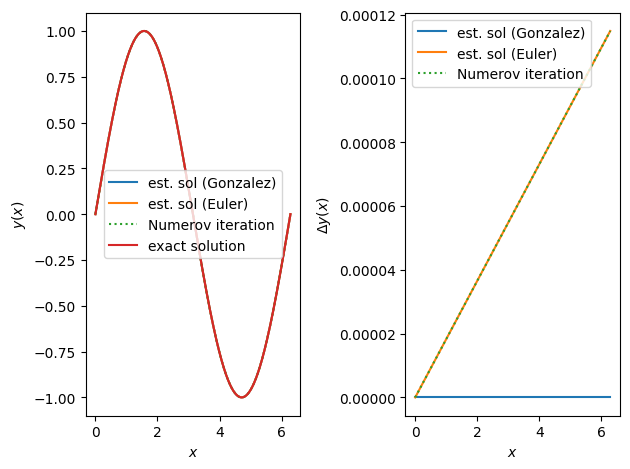

In [ ]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
y_exact = np.sin(xn)
for i, ax in enumerate(axs):
    ax.plot(xn, sol - i*y_exact, label="est. sol (Gonzalez)")
    ax.plot(xn, sol_euler - i*y_exact, label="est. sol (Euler)")
    ax.plot(xn, sol_iter-i*y_exact, ls=":", label="Numerov iteration")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\Delta y(x)$")
    if i == 0:
        ax.plot(xn, y_exact, label="exact solution")
        ax.set_ylabel("$y(x)$")
    ax.legend()

## Simple comparison with Runge-Kutta

Let's compare the Numerov method with Runge-Kutta as implemented in `solve_ivp`. The comparison involves wave functions $\psi$ and phase shifts $\delta$.

In [ ]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
# lvalues = [0]
# channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 

l = 0
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

# generate training data
rmatch = 10
grid = Grid(1e-6, rmatch, numIntervals=1, numPointsPerInterval=60000,
            type="linear", test=False)  # needs equidistant grids as of now

# generate the training points (with default method)
scattSols = RseSolver.solve(scattExp, grid, trainingLecList, method="RK45", asympParam="K")
scattSols_numerov = RseSolver.solve(scattExp, grid, trainingLecList, method="Numerov", asympParam="K")
assert np.allclose(np.real(scattSols[0].phaseShift), scattSols_numerov[0].phaseShift), "Numerov and RK45 disagree"

For the matching process, we need both $y(x)$ and $y'(x)$. We obtain the latter via finite differencing. It's good advice to do the matching not at the last grid point:

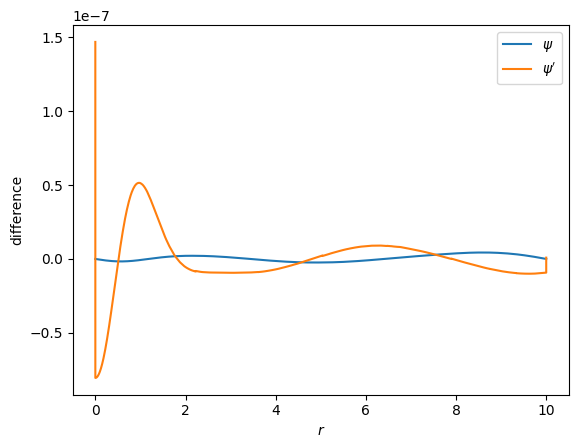

In [ ]:
import matplotlib.pyplot as plt 
from scipy.special import spherical_jn, spherical_yn
kr = scattSols[0].grid.points * scattSols[0].scattExp.p
chi = np.real(scattSols[0].u) - np.real(scattSols_numerov[0].u) 
plt.plot(scattSols[0].grid.points, chi, label="$\psi$")
chi = np.real(scattSols[0].uprime) - np.real(scattSols_numerov[0].uprime) 
plt.plot(scattSols[0].grid.points, chi, label="$\psi'$")
plt.xlabel("$r$")
plt.ylabel("difference")
plt.legend()

We can also compare the solutions for the scattered wave $\chi = \psi - \phi$:

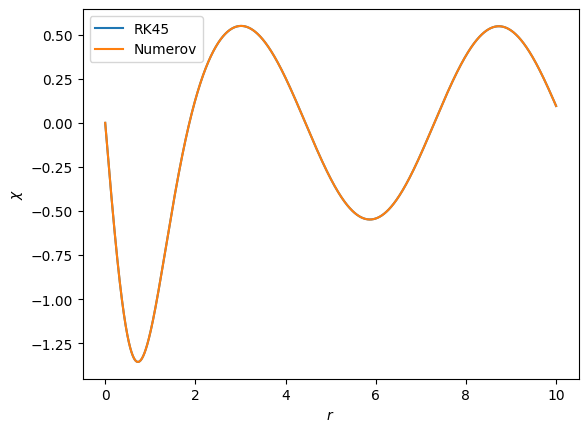

In [ ]:
import matplotlib.pyplot as plt 
from scipy.special import spherical_jn, spherical_yn
kr = scattSols[0].grid.points * scattSols[0].scattExp.p
chi = np.real(scattSols[0].u) - spherical_jn(l, kr) * kr
plt.plot(scattSols[0].grid.points, chi, label="RK45")
chi = np.real(scattSols_numerov[0].u) - spherical_jn(l, kr) * kr
plt.plot(scattSols[0].grid.points, chi, label="Numerov")
plt.xlabel("$r$")
plt.ylabel("$\chi$")
plt.legend()

### Potential future directions:

**This may be partially obsolete.**

* The Gonzalez method to implement the initial condition (for the deriviative) is highly accuracte. There's no need to implement anything else; especially, since there are open questions regarding the Adee et al. method.
* Numerov works well. But it doesn't give use (direct) access to derivatives, which are needed for the matching process (i.e., determining phase shifts). The plot above shows that, although the wave functions match well, there are noticable discrepancies between `uprime` obtained using RK45 and Numerov. 
  * What should we do about this?
  * We could improve the matching procedure to _not_ use the last point of the grid. 
* extend Numerov to variable step sizes $h$ and multi-steps to improve accuracy. Could be used to implement Gauss grida:
  * [Simos](https://www.sciencedirect.com/science/article/pii/S0021999183711721) 
  * [Medvedeva](https://onlinelibrary.wiley.com/doi/epdf/10.1002/mma.5929?saml_referrer)
  * [Vigo-Aguiar](https://link.springer.com/article/10.1007/s10910-004-1467-3)
  * Question: how to determine the step-size efficiently? References on this exist but these adaptive stepsize probably break linearity of the problem (which we need)
* Runge-Kutta 4 and 5; need to write second order diff equation as a pair of first order diff eq:
  * How long would this take?
  * means that our snapshots would have information on `u` and `uprime`. 
  * Is that an interesting feature? 
  * Do we know how to emulate this? 
* More realistic interactions:
  * Write the interaction input for the emulator in affine form. If the interaction is not affine, use hyperreduction to make them affine (EIM, as in ROSE, comes to mind).
  * We have access to the GT+ local chiral interactions. But not in the affine form needed for an efficient online/offline decomposition.
  * How can we implement non-local potentials? In momentum space and real space?
  * The original Furnstahl et al. reference could be consulted.

## Searching for spurious singularities

Josh found spurios singularities, which might be the Numerov matrix becomes ill-conditioned. Here, we search for small singular values that might explain this. Heads-up: we don't find any issues--good news! 

In [ ]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
# lvalues = [0]
# channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 

l = 0
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
# trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

# generate training data
rmatch = 10
grid = Grid(1e-6, rmatch, numIntervals=1, numPointsPerInterval=600,
            type="linear", test=False)  # needs equidistant grids as of now

# 
V0_arr = np.linspace(-500, 500, 1000)
lec_list = [{'V0': V0, 'V1': -91.85, 'K0': 1.487, 'K1': 0.465} for V0 in V0_arr]

# generate the training points (with default method)
scattSols = RseSolver.solve(scattExp, grid, lec_list, method="RK45", asympParam="K")
scattSols_numerov = RseSolver.solve(scattExp, grid, lec_list, method="Numerov", asympParam="K")

If present, the issue is likely due to the $K$ matrix being infinite (and like with $\delta = 90$ deg). We search for the location in the parameter space of the Minnesota potential. For simplicity, we vary only the paramter $V_0$:

Phaseshift reaches 90 deg at V0 = -119.61961961961958


/Users/drischler/GitHub/general_kvp/env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/drischler/GitHub/general_kvp/env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


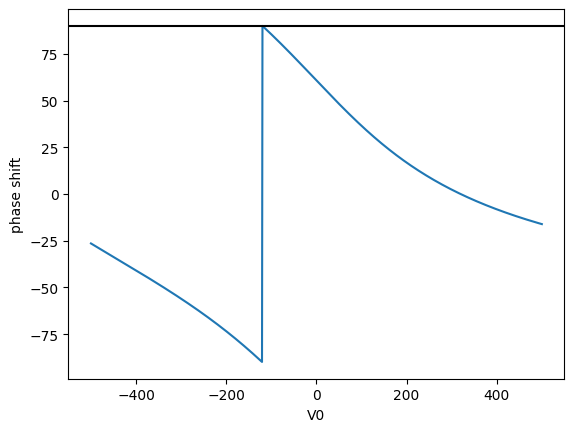

In [ ]:
phaseshifts = [elem.phaseShift for elem in scattSols]
plt.plot(V0_arr, phaseshifts)
plt.xlabel("V0")
plt.ylabel("phase shift")
plt.axhline(90, c="k")
# plt.ylim(-90, 90)
# plt.xlim(-120,-100)
arg_critical = np.argmax(phaseshifts)
V0_crit = V0_arr[arg_critical]
print("Phaseshift reaches 90 deg at V0 =", V0_crit)

Let's study the singular values as a function of $V_0$:

Text(0, 0.5, 'smallest singular value')

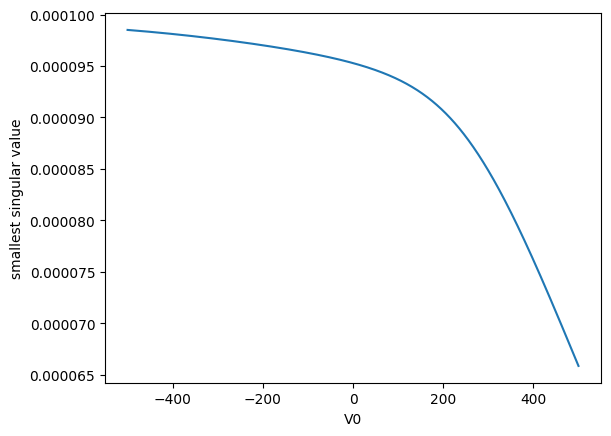

In [ ]:
# offset = 100
# sols = scattSols[arg_critical-offset:arg_critical+offset]
# V0_crit_arr = V0_arr[arg_critical-offset:arg_critical+offset]
sing_vals = [np.min(elem.singular_values) for elem in scattSols_numerov]
plt.plot(V0_arr, sing_vals)
plt.xlabel("V0")
plt.ylabel("smallest singular value")

Let's study the condition number as a function of $V_0$:

Text(0, 0.5, 'condition number')

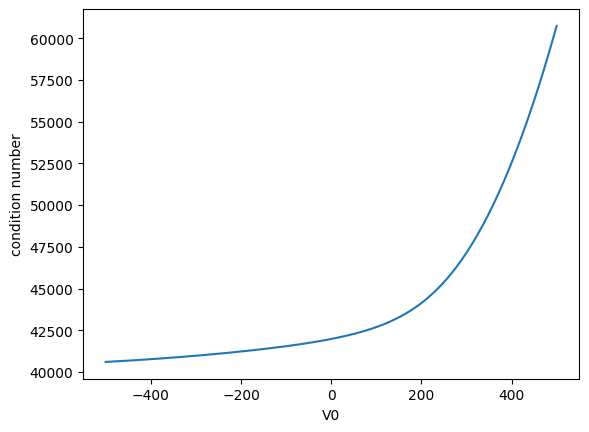

In [ ]:
sing_vals = [elem.cond for elem in scattSols_numerov]
plt.plot(V0_arr, sing_vals)
plt.xlabel("V0")
plt.ylabel("condition number")

## POD-Greedy emulator: univariate case

We test here our emulator class in the univariate case in which only $V_0$ of the Minnesota potential is varied. We don't take advantage of the affine parameter dependence to construct an efficient offline/online decomposition.

In [ ]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
l = 0
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
rmatch = 10
grid = Grid(1e-24, rmatch, numIntervals=1, numPointsPerInterval=600,
            type="linear", test=False)  # needs equidistant grids as of now
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

from NumerovEmulator import NumerovEmulator
# Test config for no greedy
emulator_pod = NumerovEmulator(potential=potential, channel=channel, scattExp=scattExp, 
                               num_snapshots_init=7, greedy_max_iter=5, num_snapshots_max=100,
                               pod=True, greedy=False, grid=grid, free_lecs=("V0",))

residual 2.573444838137122e-15
new residual 2.0275118716238096e-15
residual 1.3582677617322229e-15
new residual 1.7746165392025248e-15
residual 1.6920998199046402e-15
new residual 2.162337965755813e-15
residual 2.115563017660209e-15
new residual 2.2332639205482252e-15
residual 2.678144143650577e-15
new residual 1.3416236258139593e-15
residual 1.0609971186608903e-15
new residual 1.3248614719575867e-15
residual 1.098046888716243e-15
new residual 1.0976499672845098e-15
using 6 POD modes out of 7 in total: compression rate is 14.3 %


In [ ]:
# Test config for greedy
emulator = NumerovEmulator(potential=potential, channel=channel, scattExp=scattExp, 
                           num_snapshots_init=2, greedy_max_iter=8, num_snapshots_max=1000,
                           pod=True, greedy=True, grid=grid, free_lecs=("V0",))

using 2 POD modes out of 2 in total: compression rate is 0.0 %
greedily improving the snapshot basis:
	iteration #1 of max 8:
		estimated max error: 8.287e-04 | real max error: 6.392e+00
		adding snapshot ID 999 to current basis {698, 227}
	iteration #2 of max 8:
		estimated max error: 3.686e-05 | real max error: 1.249e-01
		adding snapshot ID 0 to current basis {698, 227, 999}
	iteration #3 of max 8:
		estimated max error: 2.793e-07 | real max error: 1.722e-03
		adding snapshot ID 881 to current basis {0, 698, 227, 999}
	iteration #4 of max 8:
		estimated max error: 3.927e-09 | real max error: 1.432e-05
		adding snapshot ID 426 to current basis {0, 227, 999, 881, 698}
	iteration #5 of max 8:
		estimated max error: 2.344e-11 | real max error: 5.599e-08
		adding snapshot ID 76 to current basis {0, 227, 999, 426, 881, 698}
	iteration #6 of max 8:
		estimated max error: 3.688e-13 | real max error: 1.896e-09
		adding snapshot ID 897 to current basis {0, 227, 999, 426, 76, 881, 698}
		added

Text(0.5, 0, '$r$')

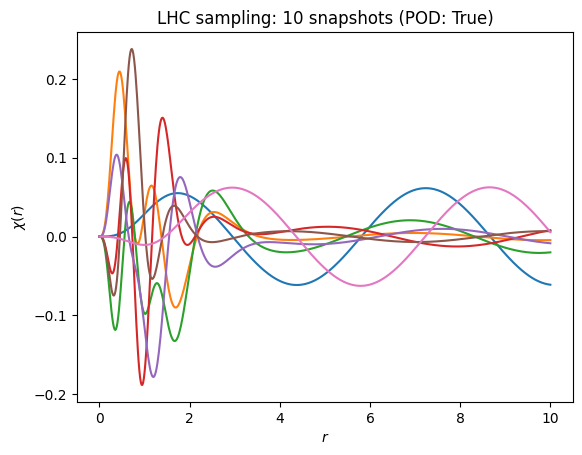

In [ ]:
import matplotlib.pyplot as plt
plt.title(f"LHC sampling: {len(emulator.lec_snapshots_idxs)} snapshots (POD: {emulator.pod})")
plt.plot(grid.points, emulator.snapshot_matrix)
plt.ylabel("$\chi(r)$")
plt.xlabel("$r$")

Text(0.5, 0, '$r$')

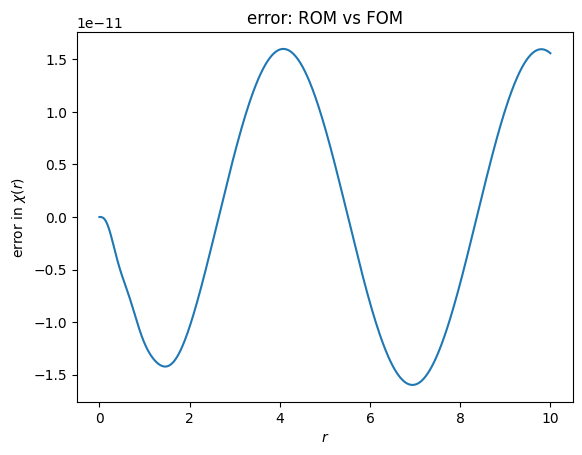

In [ ]:
romChis, romErrors, estErrBounds, fomChis, realErrors = emulator.emulate(testingLecList[:1])
plt.title("error: ROM vs FOM")
# plt.plot(grid.points[2:], romChis[0])
# plt.plot(emulator.grid.points, fomChis[0])
plt.plot(emulator.grid.points, np.real(fomChis[0])-romChis[0])
plt.ylabel("error in $\chi(r)$")
plt.xlabel("$r$")

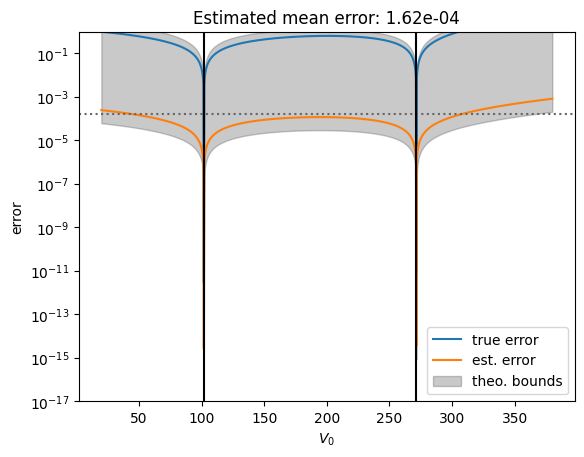

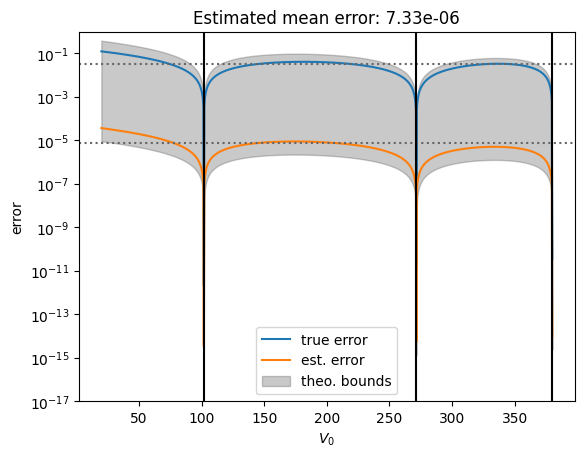

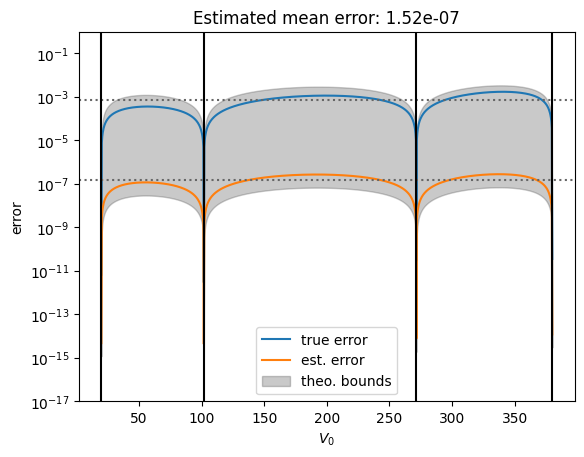

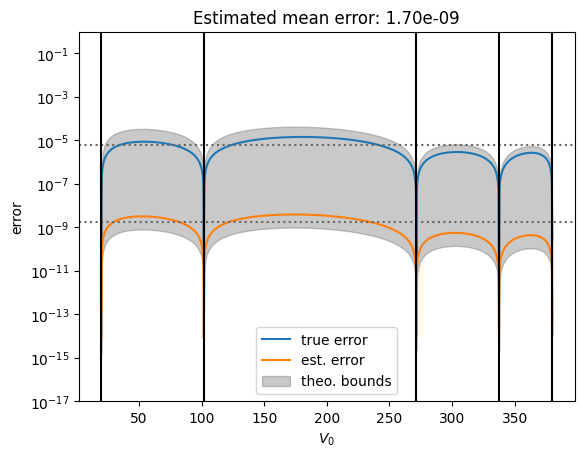

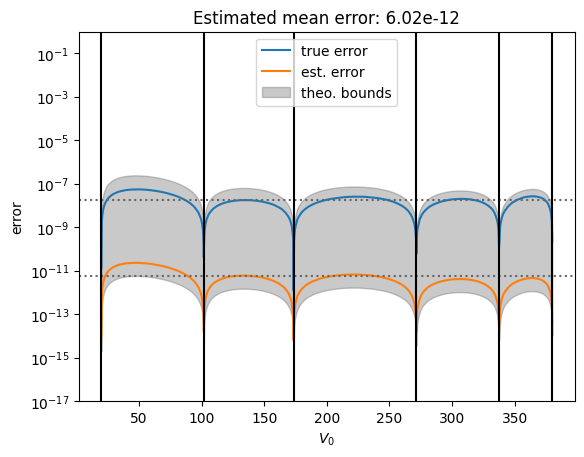

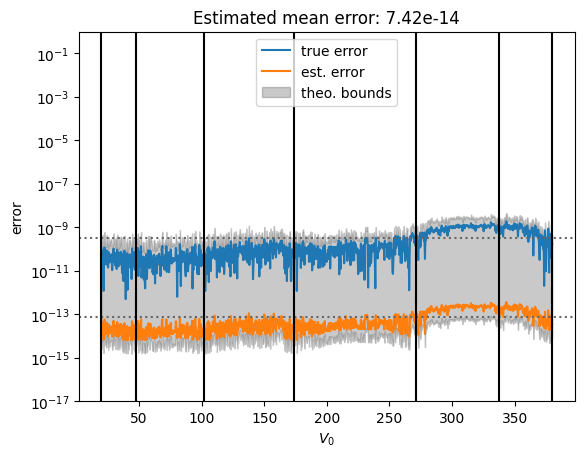

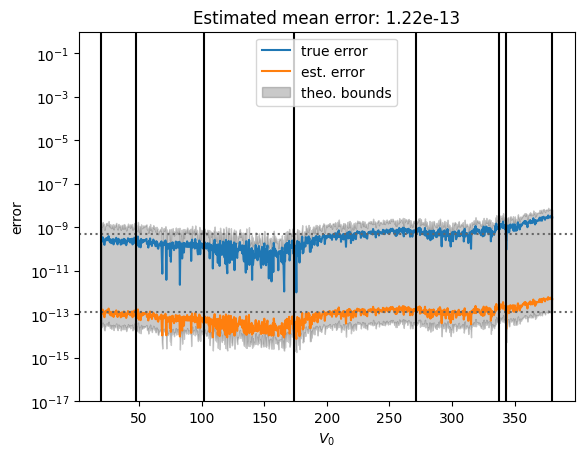

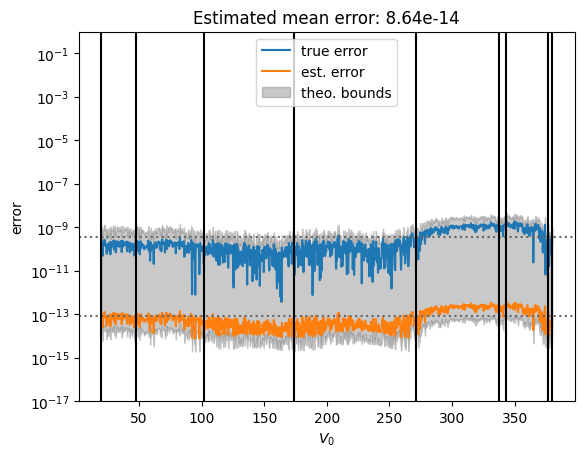

In [ ]:
num_iter = len(emulator.greedy_logging)
V0_arr = [sample["V0"] for sample in emulator.lec_all_samples]
for niter in range(num_iter):
    fig, ax = plt.subplots()
    ax.set_xlabel("$V_0$")
    ax.set_ylabel("error")
    ax.set_ylim(1e-17, 1e0)
    [snapshot_idxs, romErrors, estErrBounds, realErrors] = emulator.greedy_logging[niter]
    ax.semilogy(V0_arr, realErrors, label=f"true error")
    ax.semilogy(V0_arr, romErrors, label=f"est. error")
    # ax.semilogy(V0_arr, estErrBounds[:,0], label=f"lower bound")
    # ax.semilogy(V0_arr, estErrBounds[:,1], label=f"upper bound")
    ax.fill_between(V0_arr, estErrBounds[:,0], estErrBounds[:,1], 
                    alpha=0.3, color='0.3',
                    zorder=0, label="theo. bounds")
    for err in (romErrors,realErrors):
        ax.axhline(np.mean(err), ls=":", c='0.4')
    ax.set_title(f"Estimated mean error: {np.mean(romErrors):.2e}")

    for idx in snapshot_idxs:
        ax.axvline(emulator.lec_all_samples[idx]["V0"], c="k")
    ax.legend()

## POD-Greedy emulator: univariate case (affine case)

We test here our emulator class in the univariate case in which only $V_0$ of the Minnesota potential is varied. 

In [ ]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
l = 2
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
rmatch = 10
grid = Grid(1e-24, rmatch, numIntervals=1, numPointsPerInterval=600,
            type="linear", test=False)  # needs equidistant grids as of now
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

from NumerovEmulator import AffineNumerovEmulator
# Test config for no greedy
affineEmulator = AffineNumerovEmulator(potential=potential, channel=channel, scattExp=scattExp, 
                                       num_snapshots_init=7, greedy_max_iter=5, num_snapshots_max=100,
                                       pod=True, greedy=False, grid=grid, free_lecs=("V0",))

[-6.00000000e+48 -2.15268535e+04 -5.38080850e+03 -2.39080016e+03
 -1.34429725e+03 -8.59915898e+02 -5.96795164e+02 -4.38141661e+02
 -3.35169435e+02 -2.64572016e+02 -2.14074098e+02 -1.76711349e+02
 -1.48293914e+02 -1.26178468e+02 -1.08630538e+02 -9.44737642e+01
 -8.28874819e+01 -7.32850546e+01 -6.52381272e+01 -5.84280128e+01
 -5.26136475e+01 -4.76099601e+01 -4.32729604e+01 -3.94892631e+01
 -3.61686017e+01 -3.32383935e+01 -3.06397401e+01 -2.83244440e+01
 -2.62527577e+01 -2.43916664e+01 -2.27135642e+01 -2.11952249e+01
 -1.98169936e+01 -1.85621477e+01 -1.74163868e+01 -1.63674241e+01
 -1.54046550e+01 -1.45188883e+01 -1.37021264e+01 -1.29473831e+01
 -1.22485350e+01 -1.16001959e+01 -1.09976132e+01 -1.04365803e+01
 -9.91336325e+00 -9.42463829e+00 -8.96743894e+00 -8.53911094e+00
 -8.13727359e+00 -7.75978659e+00 -7.40472154e+00 -7.07033722e+00
 -6.75505820e+00 -6.45745625e+00 -6.17623417e+00 -5.91021159e+00
 -5.65831260e+00 -5.41955479e+00 -5.19303976e+00 -4.97794454e+00
 -4.77351421e+00 -4.57905

In [ ]:
lecs_dict = [{'Vconst': 1, 'V0': 200, 'V1': -91.85, 'K0': 1.487, 'K1': 0.465}]
lecs_arr = [np.array([lecs_dict[0][key] for key in ("Vconst", "V0", "V1")])]
params = {"scattExp": scattExp, "potential": scattExp.potential, "lecs": lecs_dict[0]}

In [ ]:
%timeit affineEmulator.simulate(lecs_arr)
%timeit affineEmulator.emulate(lecs_arr, estimate_error=False)

116 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
64.2 µs ± 395 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
print(affineEmulator.snapshot_matrix.shape, emulator_pod.snapshot_matrix.shape)
np.allclose(affineEmulator.snapshot_matrix, emulator_pod.snapshot_matrix, 
            rtol=0, atol=1e-10)

(600, 6) (600, 6)


False

In [ ]:
tmp = affineEmulator.emulate(lecs_arr, self_test=True, estimate_error=True)

In [ ]:
r = np.linspace(1.0e-4, 8, 100001)
garr = RseSolver.g(r, params)
sarr = RseSolver.s(r, params)
gs_arr = RseSolver.g_s(r, params)
assert np.allclose(garr, gs_arr[0], rtol=0, atol=1e-15)
assert np.allclose(sarr, gs_arr[1], rtol=0, atol=1e-15)
gsaff_arr = RseSolver.g_s_affine(r, params)
gaff_arr = gsaff_arr[0] @ lecs_arr[0]
saff_arr = gsaff_arr[1] @ lecs_arr[0]
assert np.allclose(gaff_arr, garr, rtol=0, atol=1e-13)
assert np.allclose(saff_arr, sarr, rtol=0, atol=1e-15)

[-5.99999999e+08 -1.85187242e+08 -8.87587608e+07 ...  1.11274870e+00
  1.11275058e+00  1.11275246e+00]


AssertionError: 

In [ ]:
r

array([1.00000e-04, 1.79999e-04, 2.59998e-04, ..., 7.99984e+00,
       7.99992e+00, 8.00000e+00])

In [ ]:
(np.abs(gaff_arr - garr))

array([1.19209290e-07, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 2.22044605e-16])

In [ ]:
%timeit emulator_pod.solve_inhomogen_rse(lecs_dict)
%timeit affineEmulator.simulate(lecs_arr)

1.94 ms ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
115 µs ± 763 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
# affineEmulator.snapshot_matrix = emulator_pod.snapshot_matrix
# affineEmulator.update_offline_stage()

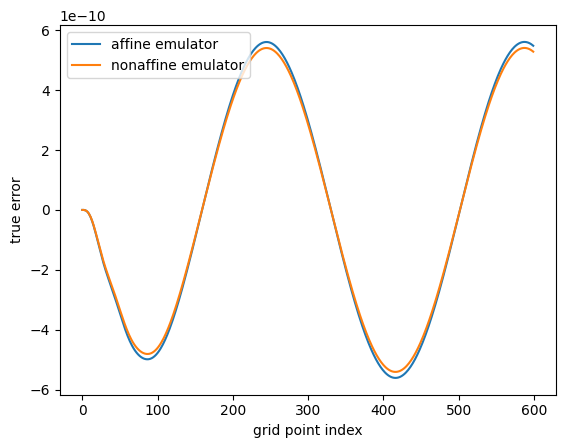

In [ ]:
a=emulator_pod.solve_inhomogen_rse(lecs_dict)
b=affineEmulator.simulate(lecs_arr)
assert np.allclose(a,b, rtol=0, atol=1e-15), "simulators don't match"

emul_pod, _, _, _, _ = emulator_pod.emulate(lecs_dict)
emul_aff = affineEmulator.emulate(lecs_arr, cond_number_threshold=1e4)
# assert np.allclose(emul_pod, emul_aff, rtol=0, atol=1e-8), "emulators don't match"

plt.plot(emul_aff[0]-b[:,0], label="affine emulator")
plt.plot(emul_pod[0]-a[:,0], label="nonaffine emulator")
plt.xlabel("grid point index")
plt.ylabel("true error")
plt.legend()

Text(0.5, 0, '$r$')

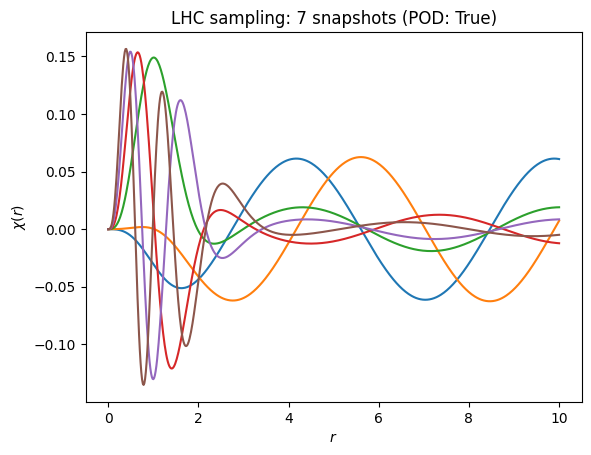

In [ ]:
import matplotlib.pyplot as plt
plt.title(f"LHC sampling: {len(affineEmulator.lec_snapshots_idxs)} snapshots (POD: {affineEmulator.pod})")
plt.plot(grid.points, affineEmulator.snapshot_matrix)
plt.ylabel("$\chi(r)$")
plt.xlabel("$r$")

In [ ]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
l = 0
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
rmatch = 10
grid = Grid(1e-24, rmatch, numIntervals=1, numPointsPerInterval=600,
            type="linear", test=False)  # needs equidistant grids as of now
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

from NumerovEmulator import AffineNumerovEmulator
# Test config for no greedy
affineEmulator_greedy = AffineNumerovEmulator(potential=potential, channel=channel, scattExp=scattExp, 
                                              num_snapshots_init=2, greedy_max_iter=8, num_snapshots_max=1000,
                                              pod=True, greedy=True, grid=grid, free_lecs=("V0",))

using 2 POD modes out of 2 in total: compression rate is 0.0 %
greedily improving the snapshot basis:
	iteration #1 of max 8:
		estimated max error: 8.287e-04 | real max error: 6.392e+00
		adding snapshot ID 999 to current basis {698, 227}
	iteration #2 of max 8:
		estimated max error: 3.686e-05 | real max error: 1.249e-01
		adding snapshot ID 0 to current basis {698, 227, 999}
	iteration #3 of max 8:
		estimated max error: 2.793e-07 | real max error: 1.722e-03
		adding snapshot ID 881 to current basis {0, 698, 227, 999}
	iteration #4 of max 8:
		estimated max error: 3.927e-09 | real max error: 1.432e-05
		adding snapshot ID 426 to current basis {0, 227, 999, 881, 698}
	iteration #5 of max 8:
		estimated max error: 2.348e-11 | real max error: 5.608e-08
		adding snapshot ID 76 to current basis {0, 227, 999, 426, 881, 698}
	iteration #6 of max 8:
		estimated max error: 6.189e-13 | real max error: 3.552e-09
		adding snapshot ID 998 to current basis {0, 227, 999, 426, 76, 881, 698}
		added

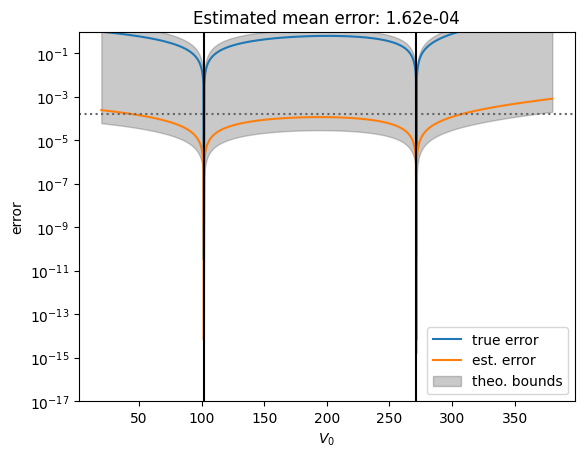

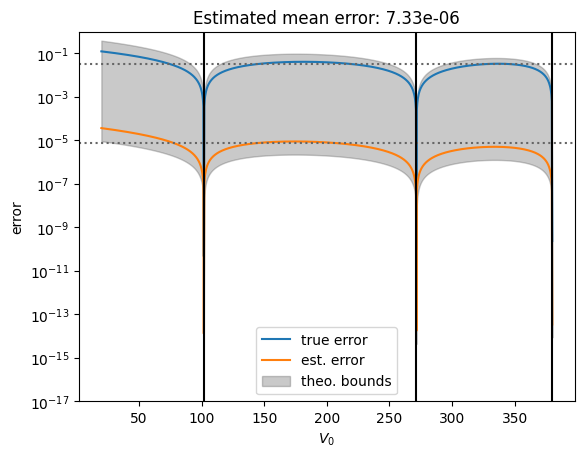

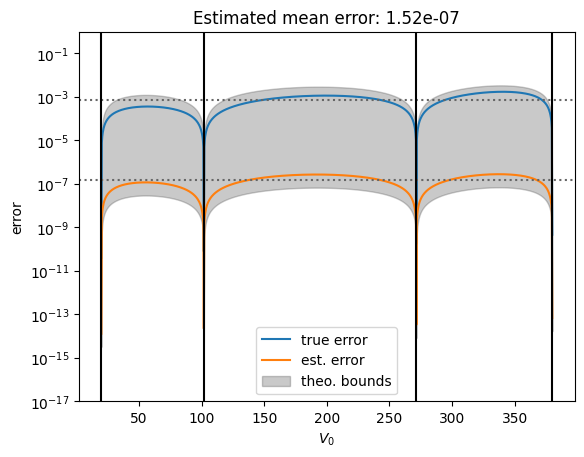

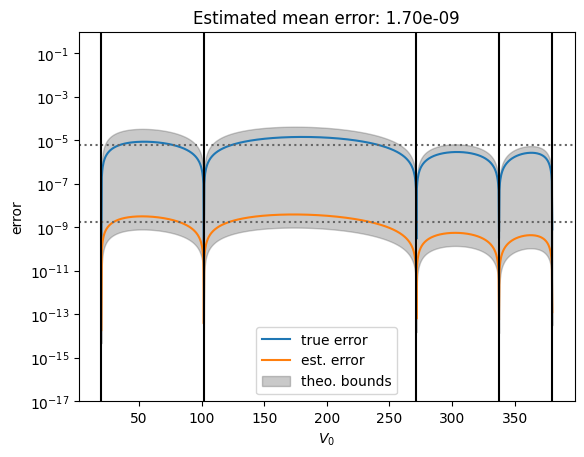

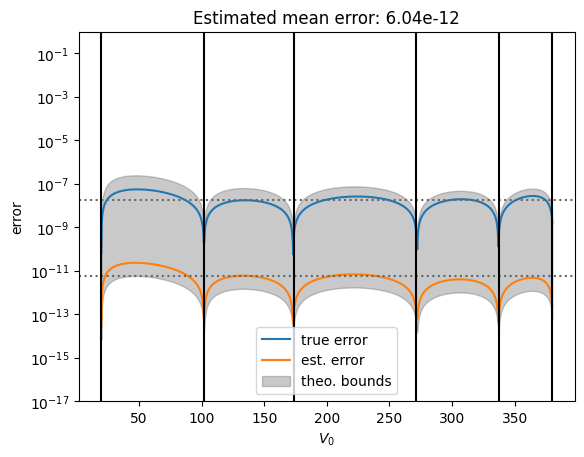

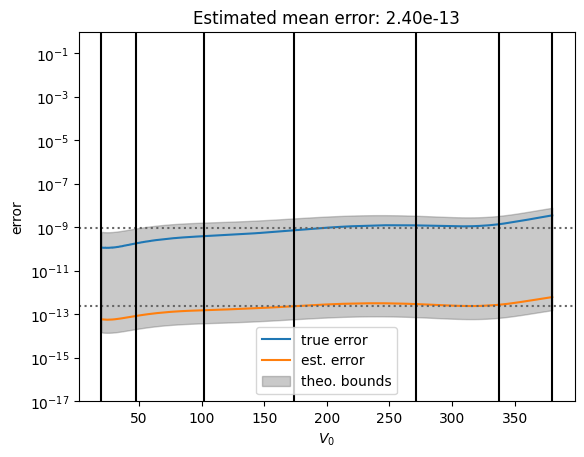

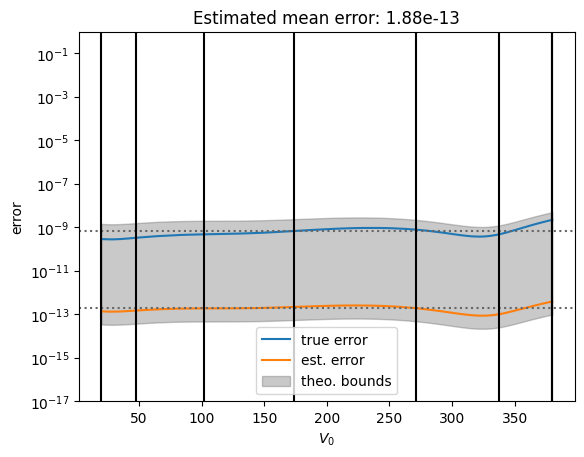

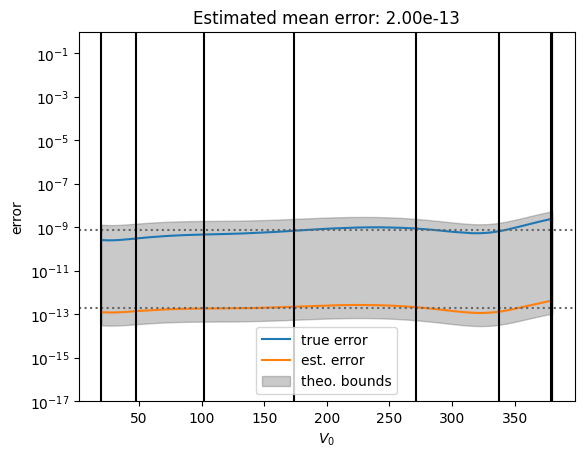

In [ ]:
num_iter = len(affineEmulator_greedy.greedy_logging)
V0_arr = affineEmulator_greedy.lec_all_samples[:,1]
for niter in range(num_iter):
    fig, ax = plt.subplots()
    ax.set_xlabel("$V_0$")
    ax.set_ylabel("error")
    ax.set_ylim(1e-17, 1e0)
    [snapshot_idxs, romErrors, estErrBounds, realErrors] = affineEmulator_greedy.greedy_logging[niter]
    ax.semilogy(V0_arr, realErrors, label=f"true error")
    ax.semilogy(V0_arr, romErrors, label=f"est. error")
    # ax.semilogy(V0_arr, estErrBounds[:,0], label=f"lower bound")
    # ax.semilogy(V0_arr, estErrBounds[:,1], label=f"upper bound")
    ax.fill_between(V0_arr, estErrBounds[:,0], estErrBounds[:,1], 
                    alpha=0.3, color='0.3',
                    zorder=0, label="theo. bounds")
    for err in (romErrors,realErrors):
        ax.axhline(np.mean(err), ls=":", c='0.4')
    ax.set_title(f"Estimated mean error: {np.mean(romErrors):.2e}")

    for idx in snapshot_idxs:
        ax.axvline(V0_arr[idx], c="k")
    ax.legend()

## Chiral potentials

We use here the local potentials [GT+](https://arxiv.org/abs/1406.0454), which are commonly used chiral potentials up to N2LO for AFDMC calculations. We wrote an affine decomposed version of the original source code provided by the developers. It matches the original, non-affine decomposed version of the code very well.

In [ ]:
from Potential import Potential, chiral, chiral_affine, chiral_lec_trafo_matrix
from Channel import Channel

potentialArgs = {"label": "chiral", "kwargs": {"potId": 233}}
l = 0
channel = Channel(S=1, L=2, LL=2, J=1, channel=0)
potential = Potential(channel, **potentialArgs)
r = 1.
aff_decomp = chiral_affine(r, channel, **potentialArgs["kwargs"])
aff_decomp

array([  -5.53041341,   15.31411662,   15.31411662, -102.3864922 ,
        307.15947659, -102.3864922 ,  307.15947659, -140.04679124,
        220.85788572, -662.57365715,    0.        ,    0.        ])

In [ ]:
import yaml
with open("data/localGT+_lecs_order_2_R0_0.9_lam_1000.yaml", 'r') as stream:
    lecs = yaml.safe_load(stream)
lecs

{'potId': 233,
 'order': 2,
 'R0': 0.9,
 'lambda': 1000,
 'CS': 7.74784,
 'CT': 0.45247,
 'C1': -0.21715,
 'C2': 0.03457,
 'C3': -0.11535,
 'C4': 0.11818,
 'C5': -2.41603,
 'C6': 0.15463,
 'C7': -0.26709,
 'CNN': 0.04164,
 'CPP': 0.06329}

In [ ]:
lec_vec = np.array([1.] + [lecs[elem] for elem in ("CS", "CT", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "CNN", "CPP")])
potval_via_aff_decomp = aff_decomp @ lec_vec
potval = chiral(r, channel, **lecs)
diff = potval_via_aff_decomp - potval
assert diff < 1e-13, f"difference (aff. vs. nonaffine evaluation): {diff:e} MeV"

Text(0, 0.5, 'V(r) [fm$^{-1}$]')

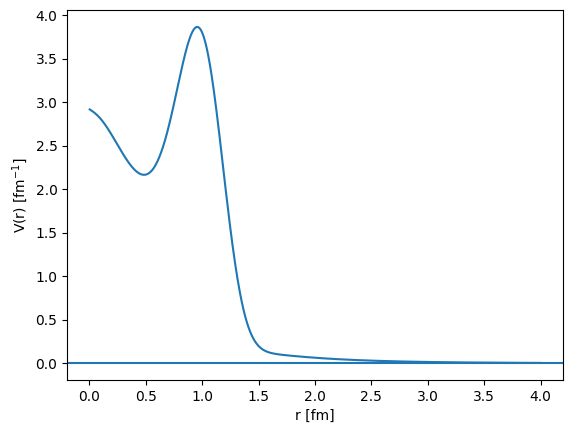

In [ ]:
hbarc = 197.326
rarr = np.linspace(0., 4., 1000)
yarr = np.array([chiral(r, channel, **lecs) for r in rarr])
plt.plot(rarr, yarr / hbarc)
plt.axhline(0)
plt.xlabel("r [fm]")
plt.ylabel("V(r) [fm$^{-1}$]")

The (Lagrangian) low-energery constants (LECs) $C_S, C_T,$ and $C_{1-7}$ were fit to NN phase shifts. In every partial wave only certain LECs contribute. In the following we give the partial 
wave decomposition for all relevant channels. We use spectroscopic LECs given in terms of $C_S, C_T,$ and $C_{1-7}$ as follows:

\begin{align}
d_{11}^{(np)} & =C_S^{(np)} + C_T \,,  \\
d_{22}^{(m_T)} & =C_S^{(m_T)}-3C_T \,, \quad m_T = \text{np}, \, \text{nn}, \, \text{pp}\\
d_{1} & =C_1-3C_2+C_3-3C_4 \,, \\
d_{2} & =C_6-3C_7 \,, \\
d_{3} & =C_1+C_2-3C_3-3C_4 \,, \\
d_{4} & =C_1+C_2+C_3+C_4 \,, \\
d_{5} & =C_1-3C_2-3C_3+9C_4 \,, \\
d_{6} & =\frac{1}{2} C_5 \,, \\
d_{7} & = C_6+C_7\,. 
\end{align}

Note that $C_S$ include isospin symmetry breaking effects. The authors defined:

$$
C_S^{(m_T)} = 
\begin{cases}
C_S  & m_T = \text{np}\\
C_S + C_{NN} & m_T = \text{nn}\\
C_S + C_{PP} & m_T = \text{pp}
\end{cases}
$$

Note the order in which the isospin channels appear. With isospin breaking affects, we can write the linear system as:

$$
\begin{pmatrix}
d_{11}^{(np)} \\
d_{22}^{(np)}\\
d_{22}^{(nn)}\\
d_{22}^{(pp)}\\
d_{1} \\
d_{2} \\
d_{3} \\
d_{4} \\
d_{5} \\
d_{6} \\
d_{7} 
\end{pmatrix}
= 
\begin{bmatrix}
1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & -3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 0 & -3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 1 & -3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & -3 & 1 & -3 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & -3 \\
0 & 0 & 0 & 0 & 1 & 1 & -3 & -3 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & -3 & -3 & 9 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac{1}{2} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1
\end{bmatrix}
\begin{pmatrix}
C_{S} \\
C_{NN}\\
C_{PP}\\
C_{T}\\
C_{1} \\
C_{2} \\
C_{3} \\
C_{4} \\
C_{5} \\
C_{6} \\
C_{7} 
\end{pmatrix}
$$

Only the terms with $d_{11}$ and $d_{22}$ are leading order (LO) LECs, the others are next-to-leading (NLO) LECs.
We define the following `numpy` array to represent this invertible linear transformation (i.e., matrix)

In [ ]:
trafo = np.array([[1 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[1 , 0 , 0 , -3 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[1 , 1 , 0 , -3 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[1 , 0 , 1 , -3 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 1 , -3 , 1 , -3 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , -3 ],
[0 , 0 , 0 , 0 , 1 , 1 , -3 , -3 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 1 , 1 , 1 , 1 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 1 , -3 , -3 , 9 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1/2 , 0 , 0 ],
[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 1]])
np.linalg.det(trafo)

-2047.9999999999984

For the partial-wave-decomposed matrix elements for the NN contact interactions, the developers provide in their appendix the following expressions

\begin{align}
\bra{^1S_0}V_{\text{cont}}\ket{^1S_0}&= d_{22}\delta_{R_0}+(d_3-d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}  \\& \quad-(d_3-d_7) \, 16 \frac{r^6}{R_0^8}\delta_{R_0} \,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3S_1}&= d_{11}\delta_{R_0}+(d_1+ \frac{1}{3} d_2)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}  \\& \quad-(d_1+ \frac{1}{3} d_2)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}\,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3D_1}&= \bra{^3D_1}V_{\text{cont}}\ket{^3S_1} \\&= d_2 \frac{\sqrt{8}}{3}\, 8\frac{r^2}{R_0^4}\delta_{R_0}-d_2 \frac{\sqrt{8}}{3}\, 16\frac{r^6}{R_0^8}\delta_{R_0}\,,  \\
\bra{^3D_1}V_{\text{cont}}\ket{^3D_1}&= d_{11}\delta_{R_0}-(d_1- \frac{1}{3} d_2)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  \\& \quad + (d_1+ \frac{3}{5} d_6 +\frac{1}{15}d_2)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^1P_1}V_{\text{cont}}\ket{^1P_1}&= \,d_{22}\delta_{R_0}+(d_5- d_2)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}  \\& \quad -(d_5- d_2)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}\,,\\
\bra{^3P_0}V_{\text{cont}}\ket{^3P_0}&= d_{11}\delta_{R_0}-(d_4-d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}   \\& \quad + (d_4+\frac{2}{5} d_6 -\frac{1}{5}d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_1}V_{\text{cont}}\ket{^3P_1}&= d_{11}\delta_{R_0}-(d_4+d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}   \\& \quad + (d_4+ \frac{1}{5} d_6 + \frac{3}{5} d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,, \\
\bra{^3P_2}V_{\text{cont}}\ket{^3P_2}&= d_{11}\delta_{R_0}-(d_4+ \frac{1}{5} d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  \\& \quad + (d_4- \frac{1}{5} d_6 +\frac{7}{25} d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_2}V_{\text{cont}}\ket{^3F_2}&= \bra{^3F_2}V_{\text{cont}}\ket{^3P_2} \\&= \, d_7 \sqrt{6}\frac{16}{5}\frac{r^2}{R_0^4}\delta_{R_0}-d_7 \sqrt{6}\frac{32}{5} \frac{r^6}{R_0^8}\delta_{R_0} \,,\\
\bra{^3F_2}V_{\text{cont}}\ket{^3F_2}&= d_{11}\delta_{R_0}-(d_4- \frac{1}{5} d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  \\& \quad + (d_4+\frac{4}{5} d_6 +\frac{3}{25} d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,.
\end{align}

Note that the labels specifying the isospin channels are omitted for brevity. In channels with $T=1$, which we can identify by the requirement that $L + S + T$ has to be odd (Pauli principle), we have 3 isospin projection channels. In channels with $T=0$, we have only 1 isospin projection channel.

Now, let's refactor these equations a bit for our purpose:

\begin{align}
\bra{^1S_0}V_{\text{cont}}\ket{^1S_0} &= d_{22}\delta_{R_0}+ \underbrace{(d_3-d_7)}_{=D_{1S_0}} \left[ 20 \frac{r^2}{R_0^4}\delta_{R_0}  - \, 16 \frac{r^6}{R_0^8}\delta_{R_0} \right] \,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3S_1} &= d_{11}\delta_{R_0} + \underbrace{(d_1+ \frac{1}{3} d_2)}_{=D_{3S_1}} \left[ 20 \frac{r^2}{R_0^4}\delta_{R_0} -  16 \frac{r^6}{R_0^8}\delta_{R_0} \right] \,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3D_1} &= \bra{^3D_1}V_{\text{cont}}\ket{^3S_1} \\&= d_2 \left[ \frac{\sqrt{8}}{3}\, 8\frac{r^2}{R_0^4}\delta_{R_0}- \frac{\sqrt{8}}{3}\, 16\frac{r^6}{R_0^8}\delta_{R_0} \right] \,,  \\
\bra{^3D_1}V_{\text{cont}}\ket{^3D_1}&= d_{11}\delta_{R_0}-\underbrace{(d_1- \frac{1}{3} d_2)}_{=D_{^3D_1}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0} + \underbrace{(d_1+ \frac{3}{5} d_6 +\frac{1}{15}d_2) }_{=D_{^3D_1}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^1P_1}V_{\text{cont}}\ket{^1P_1} &= \,d_{22}\delta_{R_0}+ \underbrace{(d_5- d_2)}_{=D_{^1P_1}}\left[ 20 \frac{r^2}{R_0^4}\delta_{R_0} - 16 \frac{r^6}{R_0^8}\delta_{R_0} \right]\,,\\
\bra{^3P_0}V_{\text{cont}}\ket{^3P_0} &= d_{11}\delta_{R_0}- \underbrace{(d_4-d_7)}_{=D_{^3P_0}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  + \underbrace{(d_4+\frac{2}{5} d_6 -\frac{1}{5}d_7)}_{=D_{^3P_0}'}\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_1}V_{\text{cont}}\ket{^3P_1}&= d_{11}\delta_{R_0}- \underbrace{(d_4+d_7)}_{=D_{^3P_1}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}   + \underbrace{(d_4+ \frac{1}{5} d_6 + \frac{3}{5} d_7)}_{=D_{^3P_1}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,, \\
\bra{^3P_2}V_{\text{cont}}\ket{^3P_2}&= d_{11}\delta_{R_0}- \underbrace{(d_4+ \frac{1}{5} d_7)}_{=D_{^3P_2}} \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  + \underbrace{(d_4- \frac{1}{5} d_6 +\frac{7}{25} d_7)}_{=D_{^3P_2}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_2}V_{\text{cont}}\ket{^3F_2}&= \bra{^3F_2}V_{\text{cont}}\ket{^3P_2} \\&= \, d_7 \left[ \sqrt{6}\frac{16}{5}\frac{r^2}{R_0^4}\delta_{R_0} -  \sqrt{6}\frac{32}{5} \frac{r^6}{R_0^8}\delta_{R_0} \right] \,,\\
\bra{^3F_2}V_{\text{cont}}\ket{^3F_2}&= d_{11}\delta_{R_0}- \underbrace{(d_4- \frac{1}{5} d_7)}_{=D_{^3F_2}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0} + \underbrace{(d_4+\frac{4}{5} d_6 +\frac{3}{25} d_7)}_{=D_{^3F_2}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,.
\end{align}

Our goal is to train different emulators in different partial wave channels. To this end, we train

Now, we define the transform that renders removes all linear combinations in these expressions:

$$
\begin{pmatrix}
d_{11}^{(np)} \\
d_{22}^{(np)}\\
d_{22}^{(nn)}\\
d_{22}^{(pp)}\\
D_{^1S_0}\\
D_{^3S_1}\\
d_{2} \\
D_{^3D_1}\\
D_{^3D_1}'\\
D_{^1P_1}\\
D_{^3P_0}\\
D_{^3P_0}'\\
D_{^3P_1}\\
D_{^3P_1}'\\
D_{^3P_2}\\
D_{^3P_2}'\\
d_{7} \\
D_{^3F_2}\\
D_{^3F_2}'
\end{pmatrix}
= 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 & 1 & \frac{1}{3} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & \frac{1}{3} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & \frac{1}{15} & 0 & 0 & 0 & \frac{3}{5} & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \frac{2}{5} & -\frac{1}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \frac{1}{5} & \frac{3}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & -\frac{1}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -\frac{1}{5} & \frac{7}{25} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & \frac{1}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \frac{4}{5} & \frac{3}{25} 
\end{bmatrix}
\begin{pmatrix}
d_{11}^{(np)} \\
d_{22}^{(np)}\\
d_{22}^{(nn)}\\
d_{22}^{(pp)}\\
d_{1} \\
d_{2} \\
d_{3} \\
d_{4} \\
d_{5} \\
d_{6} \\
d_{7} 
\end{pmatrix}
$$

**This system is overdetermined (i.e., rectangular) since we are using local chiral interactions.** That is ok since we will sample in the spectroscopic ($d$'s) or Lagrangrian ($C$'s) and then obtain the set of LECs above, in whose parameter space the emulators in each partial wave are trained on. In other words, we don't need to invert this linear system. 

Here's the `numpy` version of this matrix:

In [ ]:
import numpy as np
lin_comb = np.array(
    [[1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , -1 ],
     [0 , 0 , 0 , 0 , 1 , 1/3 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , -1 , 1/3 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 1 , 1/15 , 0 , 0 , 0 , 3/5 , 0 ],
     [0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , 1 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , 1 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 2/5 , -1/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , -1 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 1/5 , 3/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , -1/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , -1/5 , 7/25 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , 1/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 4/5 , 3/25]
])
lin_comb.shape

(19, 11)

The combined transformation matrix from the ($C_S,C_T,\ldots)$ notation to the linear combinations in the expressions is then given by: `lin_comb @ trafo`, which has the shape

In [ ]:
(lin_comb @ trafo).shape

(19, 11)

As mentioned, the linear system above is overdetermined (by construction). We can select a subset of the rows to render the system square and invertible. We choose here the subset of rows that maximizes the absolute value of the determinant of the remaining (square) system. We call this subset the non-redundant rows (or constraints) and the remaining the redundant rows:

In [ ]:
from itertools import combinations
all_rows = range(19)
idxs = list(combinations(all_rows, r=11))
res = [np.linalg.det(lin_comb[row_idxs,:]) for row_idxs in idxs]
nonredundant_rows = list(idxs[np.argmax(np.abs(res))])  # could also use argmax()
redundant_rows = list(set(all_rows) - set(nonredundant_rows))
print("indices of the nonredundant rows (choice): ", nonredundant_rows)
print("indices of the corresponding redundant rows:", redundant_rows)
print("determinant of neduced matrix:", np.linalg.det(lin_comb[nonredundant_rows,:]))


indices of the nonredundant rows (choice):  [0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 18]
indices of the corresponding redundant rows: [7, 8, 11, 13, 14, 15, 16, 17]
determinant of neduced matrix: 1.6


In addition, we also deal with (up to 3) different constant terms in the potential, $V_\mathrm{const}^{(m_T)}$, corresponding to the isospin channels. However, in a given channel, such as $^1S_0^{(\mathrm{np})}$, only one $V_\mathrm{const}^{(m_T)}$ contributes.

## POD-Greedy emulator: multivariate case

Let's vary now the two (affine) parameters of the Minnesota potential. We sample the two-dimensional phase space:

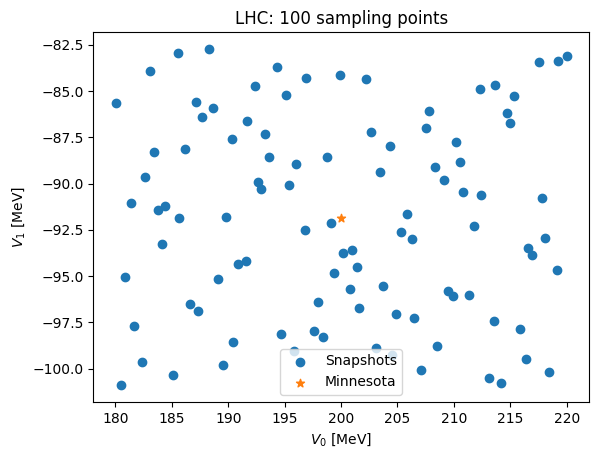

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def sample_parameter_space(n, range_factor=0.1):
    from scipy.stats import qmc
    sampler = qmc.LatinHypercube(d=2, seed=123)
    sample = sampler.random(n)
    base = np.array([200, -91.85])  # Minnesota best fit
    l_bounds = base - range_factor * np.abs(base)
    u_bounds = base + range_factor * np.abs(base)
    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
    return base, sample_scaled

base, lec_snapshot_samples = sample_parameter_space(n=100)
plt.title(f"LHC: {lec_snapshot_samples.shape[0]} sampling points")
plt.scatter(lec_snapshot_samples[:,0], lec_snapshot_samples[:,1], label="Snapshots")
plt.scatter(base[0], base[1], marker="*", label="Minnesota")
plt.xlabel("$V_0$ [MeV]")
plt.ylabel("$V_1$ [MeV]")
plt.legend()

**It's more convenient to use the new sampling function in the potential class.**